# CASA0002_Urban simulation Assignment

<div style="float:left">
            <h1 style="width:450px">Code Part 1</h1>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>


Assignment requirements [here](https://github.com/yiyansun/urbsim/blob/main/assessment/AssessUrbanSim2024.pdf)

Marking scheme [here](https://github.com/yiyansun/urbsim/blob/main/assessment/UrbanSim_Marking_Scheme.pdf)

Code is available [here](https://github.com/yiyansun/urbsim/blob/main/assessment/Part1.ipynb)

[Data](https://github.com/yiyansun/urbsim/tree/main/assessment/data) : London underground graph and london_flow.csv

In [146]:
import requests
import urllib.request
import io

import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import heapq
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance
from statistics import mean

# Part 1: London’s underground resilience

## 1. Topological network

> understand the vulnerability of the London Underground network to random failures and targeted attacks. The London Underground network is a complex system of interconnected stations and lines. The network is represented as a graph, where stations are nodes and connections between stations are edges. The graph is undirected and unweighted, meaning that connections between stations are bidirectional and do not have associated travel times. The graph is also connected, meaning that there is a path between any two stations in the network. 34 marks

> Evaluate the resilience of the London’s underground through the removal of 
stations that can potentially make the underground vulnerable. Through the procedure outlined below 
you will investigate which are the stations that are most critical for the functioning of the 
underground, and which methodology is more appropriate to finding these stations.

In [147]:
# read the london tube network graphml file
url = "https://github.com/yiyansun/urbsim/raw/main/assessment/data/london_tubenetwork.graphml"
with urllib.request.urlopen(url) as response:
    content = response.read().decode('utf-8')
file = io.StringIO(content)

# Read the GraphML content and create the graph
G = nx.read_graphml('data/london.graph')
# Check the type of G
print(type(G))

<class 'networkx.classes.graph.Graph'>


In [148]:
london_flows = pd.read_csv('https://raw.githubusercontent.com/yiyansun/urbsim/main/assessment/data/london_flows.csv')
london_flows.head()

station_origin station_destination  flows  population   jobs     distance
0     Abbey Road   Bank and Monument      0         599  78549  8131.525097
1     Abbey Road             Beckton      1         599    442  8510.121774
2     Abbey Road           Blackwall      3         599    665  3775.448872
3     Abbey Road        Canary Wharf      1         599  58772  5086.514220
4     Abbey Road        Canning Town     37         599  15428  2228.923167

In [149]:
# Get the number of nodes and edges in the Tube network
num_nodes_tube = G.number_of_nodes()
num_edges_tube = G.number_of_edges()

print("Number of nodes in the tube network:", G.number_of_nodes())
print("Number of edges in the tube network:", G.number_of_edges())

Number of nodes in the tube network: 401
Number of edges in the tube network: 467


### 1.1 Centrality measures:

> Select 3 centrality measures to characterise nodes, aiming at identifying the most important nodes in 
the underground network. Give the definition of each of the measures (including their equation), put 
the measures into the context of the underground, and why they will allow you to find the stations that 
are most crucial for the functioning of the underground. Compute the measures for your nodes in the 
network, and give the results in a table for the first 10 ranked nodes for each of the 3 measures.

> 6 (2 per measure)


Here we choose
- Degree centrality
- Closeness centrality
- Betweeness centrality  

#### 1.1.1 Degree centrality

In [150]:
file_network = nx.read_graphml('data/london.graph')
deg_london_network = nx.degree(file_network)
degree_centrality = pd.DataFrame(deg_london_network, columns=['stations', 'degree'])
degree_centrality = degree_centrality.sort_values(by=['degree'], ascending=False)
degree_centrality[:10]

stations  degree
5                   Stratford       9
50          Bank and Monument       8
229  King's Cross St. Pancras       7
18               Baker Street       7
180              Earl's Court       6
45              Oxford Circus       6
51           Liverpool Street       6
14                   Waterloo       6
16                 Green Park       6
7                Canning Town       6

In [151]:
clos_london_network = nx.closeness_centrality(file_network, distance='distance')
closeness_centrality = pd.DataFrame.from_dict(clos_london_network, columns=['closeness'], orient='index').reset_index()
closeness_centrality = closeness_centrality.sort_values(by=['closeness'], ascending=False)
closeness_centrality.rename(columns={'index': 'stations'}, inplace=True)
closeness_centrality[:10]

stations  closeness
16                 Green Park   0.114778
50          Bank and Monument   0.113572
229  King's Cross St. Pancras   0.113443
15                Westminster   0.112549
14                   Waterloo   0.112265
45              Oxford Circus   0.111204
17                Bond Street   0.110988
230                Farringdon   0.110742
312                     Angel   0.110742
232                  Moorgate   0.110314

In [152]:
bet_london_network = nx.betweenness_centrality(file_network, weight='distance')
betweenness_centrality = pd.DataFrame.from_dict(bet_london_network, columns=['betweenness'], orient='index').reset_index()
betweenness_centrality = betweenness_centrality.sort_values(by=['betweenness'], ascending=False)
betweenness_centrality.rename(columns={'index': 'stations'}, inplace=True)
betweenness_centrality[:10]

stations  betweenness
5                   Stratford     0.297846
50          Bank and Monument     0.290489
51           Liverpool Street     0.270807
229  King's Cross St. Pancras     0.255307
14                   Waterloo     0.243921
16                 Green Park     0.215835
150                    Euston     0.208324
15                Westminster     0.203335
18               Baker Street     0.191568
21              Finchley Road     0.165085

In [153]:
degree=nx.degree_centrality(G)
nx.set_node_attributes(G,dict(degree),'degree')

# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

# Sort DataFrame by degree centrality in descending order and display top 10
df_sorted = df.sort_values(["degree"], ascending=False)
degree_centrality = df_sorted[0:10]
degree_centrality

station_name  degree
Stratford                         NaN  0.0225
Bank and Monument                 NaN  0.0200
King's Cross St. Pancras          NaN  0.0175
Baker Street                      NaN  0.0175
Earl's Court                      NaN  0.0150
Oxford Circus                     NaN  0.0150
Liverpool Street                  NaN  0.0150
Waterloo                          NaN  0.0150
Green Park                        NaN  0.0150
Canning Town                      NaN  0.0150

In [154]:
degree_centrality = pd.DataFrame(nx.degree(G), columns=['degree(nonseq)', 'value']) \
                      .sort_values(by='value', ascending=False) \
                      .iloc[:10]
degree_centrality

degree(nonseq)  value
5                   Stratford      9
50          Bank and Monument      8
229  King's Cross St. Pancras      7
18               Baker Street      7
180              Earl's Court      6
45              Oxford Circus      6
51           Liverpool Street      6
14                   Waterloo      6
16                 Green Park      6
7                Canning Town      6

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

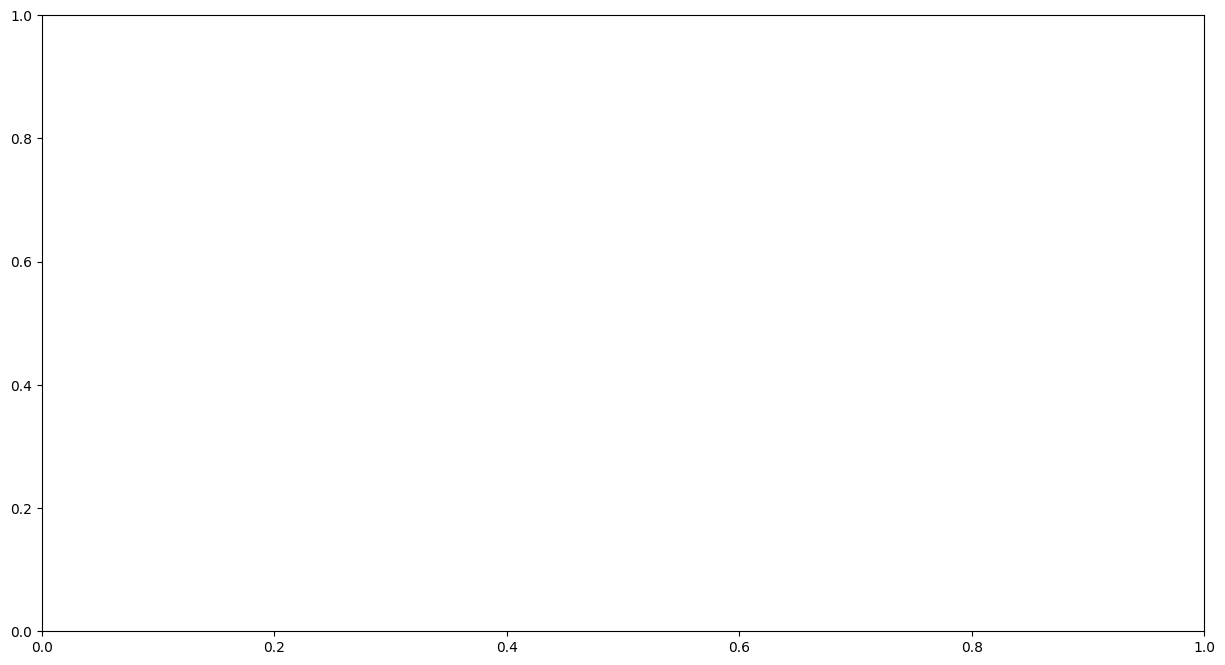

In [155]:

pos = nx.get_node_attributes(G, 'coords')

degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]

deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]

fig, ax = plt.subplots(figsize=(15,8))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)

plt.colorbar(nod,label="Degree Centrality",orientation="vertical", shrink=0.5)
plt.axis("off")
plt.title("Underground Degree Centrality",fontsize=15)
plt.savefig("output/degree_centrality.png", format="PNG")
plt.show()

#### 1.1.2 Betweenness centrality

**Definition:** Betweenness centrality quantifies the significance of a node based on how often it serves as a bridge or intermediary along the shortest paths between other nodes in the network. This measure underscores nodes that, although they might not be highly connected themselves, play a crucial role in controlling the flow of information through the network.


betweenness centrality on nodes

In [156]:
bet_t=nx.betweenness_centrality(G,normalized=True,weight='length')

# add these values to the nodes attributes:
nx.set_node_attributes(G,bet_t,'betweenness')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['betweenness'] = pd.Series(nx.get_node_attributes(G, 'betweenness'))

df_sorted = df.sort_values(["betweenness"], ascending=False)
betweenness_centrality = df_sorted[0:10]
betweenness_centrality

station_name  betweenness
Bank and Monument                 NaN     0.221253
King's Cross St. Pancras          NaN     0.209185
Stratford                         NaN     0.182306
Oxford Circus                     NaN     0.169937
Euston                            NaN     0.165915
Baker Street                      NaN     0.152256
Earl's Court                      NaN     0.143797
Shadwell                          NaN     0.139449
Waterloo                          NaN     0.130426
South Kensington                  NaN     0.129511

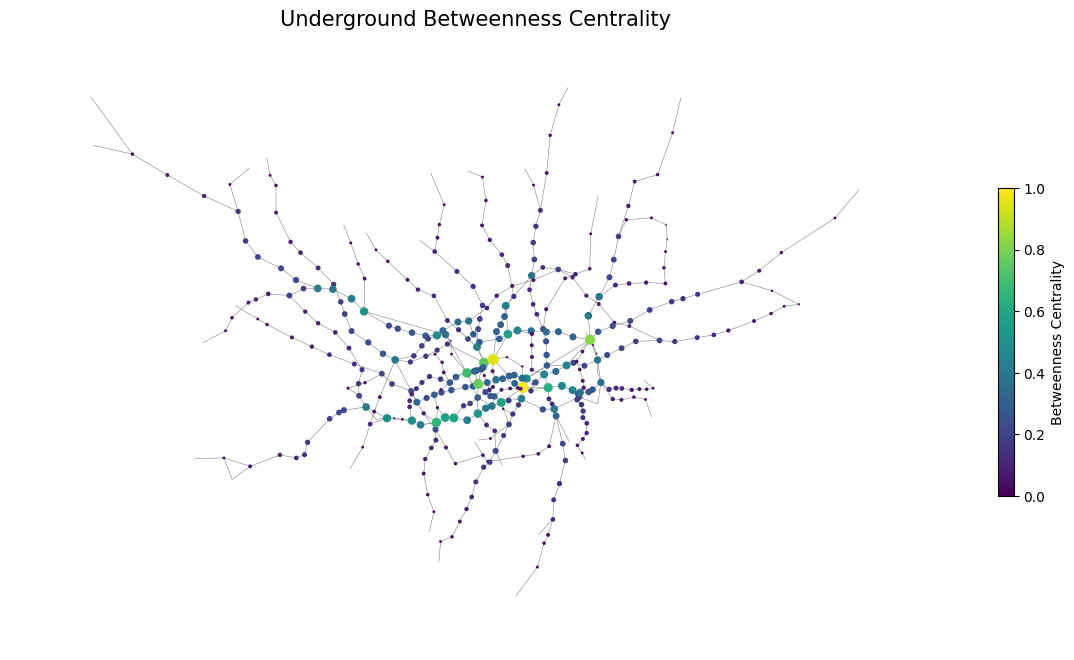

In [ ]:
# plot 
bet_values=[(i[1]['betweenness']) for i in G.nodes(data=True)]

bet_color=[(i[1]['betweenness']/(max(bet_values))) for i in G.nodes(data=True)]
bet_size=[(i[1]['betweenness']/(max(bet_values)))*50 for i in G.nodes(data=True)]

pos=pos

fig, ax = plt.subplots(figsize=(15,8))

nx.draw_networkx_edges(G, pos,edge_color='gray',
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_color,
        node_size= bet_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="vertical", shrink=0.5)
plt.axis("off")
plt.title("Underground Betweenness Centrality",fontsize=15)
plt.savefig("output/betweenness_centrality.png", format="PNG")
plt.show()

#### 1.1.3 Closeness centrality

**Definition:** Closeness centrality measures the reciprocal of the mean geodesic distance (shortest path) from a given node to all other nodes in the network. A node that is closer to most other nodes and has a low mean geodesic distance is deemed to be more central, indicating that it can reach other nodes more quickly than those with higher mean geodesic distances.


In [157]:
#Weighted closeness centrality: 
clos_t=nx.closeness_centrality(G)
# add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness')

# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['closeness'] = pd.Series(nx.get_node_attributes(G, 'closeness'))

df_sorted = df.sort_values(["closeness"], ascending=False)
closeness_centrality = df_sorted[0:10]
closeness_centrality

station_name  closeness
Green Park                        NaN   0.114778
Bank and Monument                 NaN   0.113572
King's Cross St. Pancras          NaN   0.113443
Westminster                       NaN   0.112549
Waterloo                          NaN   0.112265
Oxford Circus                     NaN   0.111204
Bond Street                       NaN   0.110988
Farringdon                        NaN   0.110742
Angel                             NaN   0.110742
Moorgate                          NaN   0.110314

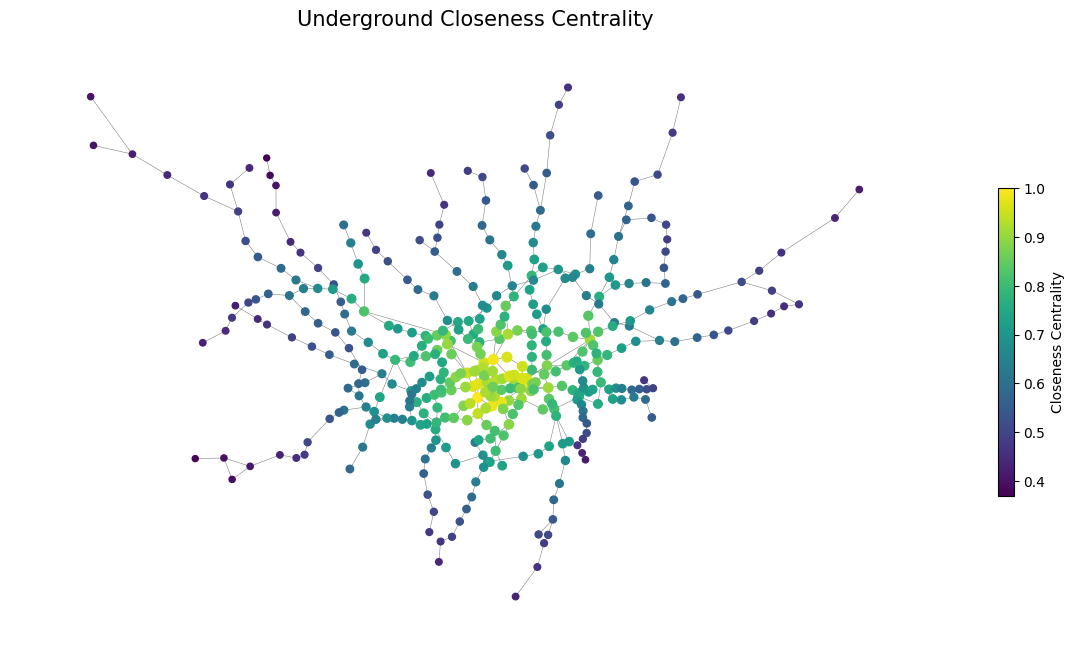

In [ ]:
# plot 
clos_values=[(i[1]['closeness']) for i in G.nodes(data=True)]

clos_color=[(i[1]['closeness']/(max(clos_values))) for i in G.nodes(data=True)]
clos_size=[(i[1]['closeness']/(max(clos_values)))*50 for i in G.nodes(data=True)]

pos=pos

fig, ax = plt.subplots(figsize=(15,8))

nx.draw_networkx_edges(G, pos,edge_color='gray',
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= clos_color,
        node_size= clos_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="vertical", shrink=0.5)
plt.axis("off")
plt.title("Underground Closeness Centrality",fontsize=15)
plt.savefig("output/closeness_centrality.png", format="PNG")
plt.show()

Merge the results of three centrality measures into one DataFrame

In [158]:
top_stations_nonseq = pd.concat([degree_centrality.reset_index(drop=True),
                                 betweenness_centrality.reset_index(drop=True),
                                 closeness_centrality.reset_index(drop=True)], axis=1)

# Add a column named "Rank" indicating the ranking of nodes across different centrality measures
top_stations_nonseq.insert(0, 'Rank', range(1, 11))

top_stations_nonseq

Rank            degree(nonseq)  value station_name  betweenness  \
0     1                 Stratford      9          NaN     0.221253   
1     2         Bank and Monument      8          NaN     0.209185   
2     3  King's Cross St. Pancras      7          NaN     0.182306   
3     4              Baker Street      7          NaN     0.169937   
4     5              Earl's Court      6          NaN     0.165915   
5     6             Oxford Circus      6          NaN     0.152256   
6     7          Liverpool Street      6          NaN     0.143797   
7     8                  Waterloo      6          NaN     0.139449   
8     9                Green Park      6          NaN     0.130426   
9    10              Canning Town      6          NaN     0.129511   

  station_name  closeness  
0          NaN   0.114778  
1          NaN   0.113572  
2          NaN   0.113443  
3          NaN   0.112549  
4          NaN   0.112265  
5          NaN   0.111204  
6          NaN   0.110988  
7          NaN   0.110742  
8          NaN   0.110742  
9          NaN   0.110314

### 1.2 Impact measures:

> Find 2 different measures to evaluate the impact of the node removal on the network. These need to 
be global measures referring to the whole network and not to specific nodes or links. Explain whether 
these two measures are specific to the London underground, or whether they could also be used to 
evaluate the resilience of any other network.

> 8 (4 per measure)

#### 1.2.1 Average degree

**Definition:** The average degree of a network is the mean value of the degrees of all nodes in the network. 

\begin{equation}
\text{Average Degree} = \frac{\sum_{i} D_i}{n}
\end{equation}

Where \(D\) is the degree of each node, \(n\) is the total number of nodes in the network.

#### 1.2.2 Global efficiency

**Definition:** Global efficiency is a measure that quantifies the efficiency of information or traffic exchange over a network. It's the average of the inverse shortest path length between every pair of nodes. Mathematically:

\begin{equation}
\text{Global Efficiency} = \frac{1}{n(n-1)} \sum_{i \neq j} \frac{1}{d_{ij}}
\end{equation}

Where \(d_{ij}\) is the shortest path distance between nodes \(i\) and \(j\), and \(n\) is the total number of nodes.

### 1.3. Node removal

> For each of the centrality measures selected in I.1. remove at least 10 nodes following two different 
strategies.   20

>> A) Non-sequential removal: using the table created in I.1. remove 1 node at a time 
following the rank in the table, i.e. from the most important one to the 10th most important one. After 
each removal, evaluate the impact of the removal using your two measures in I.2. and proceed until 
you have removed at least 10 nodes. 

>> B) Sequential: remove the highest ranked node and evaluate the 
impact using the 2 measures. After removal, re-compute the centrality measure. Remove the highest 
ranked node in the new network and evaluate the impact. Continue until removing at least 10 nodes.

> Report the results of the 2 strategies in one plot, and critically discuss the following: which centrality 
measure reflects better the importance of a station for the functioning of the underground, which 
strategy is more effective at studying resilience, and which impact measure is better at assessing the 
damage after node removal

#### 1.3.1 non-sequential removal

In [142]:
top_stations_nonseq

Rank            degree(nonseq)  value station_name  betweenness  \
0     1                 Stratford      9          NaN     0.221253   
1     2         Bank and Monument      8          NaN     0.209185   
2     3  King's Cross St. Pancras      7          NaN     0.182306   
3     4              Baker Street      7          NaN     0.169937   
4     5              Earl's Court      6          NaN     0.165915   
5     6             Oxford Circus      6          NaN     0.152256   
6     7          Liverpool Street      6          NaN     0.143797   
7     8                  Waterloo      6          NaN     0.139449   
8     9                Green Park      6          NaN     0.130426   
9    10              Canning Town      6          NaN     0.129511   

  station_name  closeness  
0          NaN   0.114778  
1          NaN   0.113572  
2          NaN   0.113443  
3          NaN   0.112549  
4          NaN   0.112265  
5          NaN   0.111204  
6          NaN   0.110988  
7          NaN   0.110742  
8          NaN   0.110742  
9          NaN   0.110314

#### 1.3.2 sequential removal

In [170]:
degree_centrality_seq = []
station_names = []

# Create a copy of the original graph G to avoid modifying it directly.
G_dc_seq = G.copy()

for i in range(10):
    degree = nx.degree(G_dc_seq)
    nx.set_node_attributes(G_dc_seq, dict(degree), 'degree')
    
    degree_df = pd.DataFrame.from_dict(dict(degree), columns=['degree'], orient='index')
    node = degree_df.sort_values('degree', ascending=False).index[0] # Find the node with the highest degree centrality.
    station_name = G_dc_seq.nodes[node] 
    station_names.append(station_name)
    
    degree_centrality_seq.append(station_name)
    G_dc_seq.remove_node(node)

degree_centrality_seq


[{'coords': '(538524.7855297636, 184373.34100822973)',
  'degree': 9,
  'betweenness': 0.18230576441102758,
  'closeness': 0.10438413361169102},
 {'coords': '(532821.10615604, 180978.99742206652)',
  'degree': 8,
  'betweenness': 0.2212531328320802,
  'closeness': 0.1135718341851221},
 {'coords': '(528063.3393097348, 182010.5333398169)',
  'degree': 7,
  'betweenness': 0.15225563909774437,
  'closeness': 0.1089621356578589},
 {'coords': '(530299.5672470357, 182969.18209262053)',
  'degree': 7,
  'betweenness': 0.2091854636591479,
  'closeness': 0.11344299489506524},
 {'coords': '(525466.7699525921, 178494.18714144814)',
  'degree': 6,
  'betweenness': 0.143796992481203,
  'closeness': 0.09041591320072333},
 {'coords': '(528968.085643932, 180259.31506057666)',
  'degree': 6,
  'betweenness': 0.06382205513784461,
  'closeness': 0.11477761836441894},
 {'coords': '(539439.020753582, 181338.40907066417)',
  'degree': 6,
  'betweenness': 0.07771929824561404,
  'closeness': 0.0915750915750915

In [166]:
degree_centrality_seq = []
station_names = []

# Create a copy of the original graph G to avoid modifying it directly.
G_dc_seq = G.copy()

for i in range(10):
    degree = nx.degree(G_dc_seq)
    nx.set_node_attributes(G_dc_seq, dict(degree), 'degree')
    
    degree_df = pd.DataFrame.from_dict(dict(degree), columns=['degree'], orient='index')
    node = degree_df.sort_values('degree', ascending=False).index[0] # Find the node with the highest degree centrality.
    station_name = G_dc_seq.nodes[node]['station_name'] 
    station_names.append(station_name)
    
    degree_centrality_seq.append(station_name)
    G_dc_seq.remove_node(node)

degree_centrality_seq


KeyError: 'station_name'

In [16]:
betweenness_centrality_seq = []
G_bc_seq = G.copy()

for i in range(10):
    betweenness = nx.betweenness_centrality(G_bc_seq, normalized=True, weight='length')
    nx.set_node_attributes(G_bc_seq, betweenness, 'betweenness')
    
    betweenness_df = pd.DataFrame.from_dict(betweenness, columns=['betweenness'], orient='index')
    node = betweenness_df.sort_values('betweenness', ascending=False).index[0] # Find the node with the highest betweenness centrality.
    station_name = G_bc_seq.nodes[node]['station_name'] 
    
    betweenness_centrality_seq.append(station_name)
    G_bc_seq.remove_node(node)
    
betweenness_centrality_seq

['Baker Street',
 'Bethnal Green',
 "Earl's Court",
 'Notting Hill Gate',
 'West Hampstead',
 'Bank',
 'Mile End',
 'Canary Wharf',
 'Canning Town',
 'Ealing Common']

In [17]:
closeness_centrality_seq = []
station_names = []

G_cc_seq = G.copy()

for i in range(10):
    closeness = nx.closeness_centrality(G_cc_seq)
    nx.set_node_attributes(G_cc_seq, closeness, 'closeness')
    
    closeness_df = pd.DataFrame.from_dict(closeness, columns=['closeness'], orient='index')
    node = closeness_df.sort_values('closeness', ascending=False).index[0] # Find the node with the highest closeness centrality.
    station_name = G_cc_seq.nodes[node]['station_name'] 
    station_names.append(station_name)
    
    closeness_centrality_seq.append(station_name)
    G_cc_seq.remove_node(node)

closeness_centrality_seq

['Green Park',
 'Baker Street',
 'Liverpool Street',
 'Canary Wharf',
 'Embankment',
 'Canning Town (DLR)',
 'Harrow-on-the-Hill',
 'High Street Kensington',
 'Bank',
 'Stratford (Rail)']

reassamble the results of node removal into one DataFrame

In [18]:
top_stations_seq= pd.DataFrame({'degree(seq)': degree_centrality_seq, 'closeness(seq)': closeness_centrality_seq, 'betweenness(seq)': betweenness_centrality_seq})
top_stations_seq .insert(0,'Rank',range(1,11))
top_stations_seq

Rank               degree(seq)          closeness(seq)   betweenness(seq)
0     1  King's Cross St. Pancras              Green Park       Baker Street
1     2              Baker Street            Baker Street      Bethnal Green
2     3                  Waterloo        Liverpool Street       Earl's Court
3     4                Green Park            Canary Wharf  Notting Hill Gate
4     5              Earl's Court              Embankment     West Hampstead
5     6        Canning Town (DLR)      Canning Town (DLR)               Bank
6     7             Oxford Circus      Harrow-on-the-Hill           Mile End
7     8          Liverpool Street  High Street Kensington       Canary Wharf
8     9             Turnham Green                    Bank       Canning Town
9    10                      none        Stratford (Rail)      Ealing Common

In [19]:
top_staions = pd.merge(top_stations_nonseq, top_stations_seq, on='Rank')
top_staions

Rank degree(nonseq)  value              station_name  betweenness  \
0     1    940GZZLUKSX      7              Baker Street     0.385594   
1     2    940GZZLUBST      7             Finchley Road     0.312661   
2     3    940GZZLUOXC      6          Liverpool Street     0.270317   
3     4    940GZZLUGPK      6            West Hampstead     0.270264   
4     5    940GZZLUBNK      6            West Hampstead     0.269624   
5     6    940GZZLUECT      6  King's Cross St. Pancras     0.258518   
6     7    940GZZLUWLO      6                      Bank     0.221349   
7     8    940GZZLUTNG      5                  Mile End     0.186415   
8     9    940GZZDLCGT      5             Oxford Circus     0.181775   
9    10    940GZZLULVT      5             Bethnal Green     0.180663   

       station_name  closeness               degree(seq)  \
0        Green Park   0.094897  King's Cross St. Pancras   
1       Bond Street   0.093737              Baker Street   
2       Westminster   0.093197                  Waterloo   
3      Baker Street   0.092900                Green Park   
4          Waterloo   0.092389              Earl's Court   
5              Bank   0.092000        Canning Town (DLR)   
6     Oxford Circus   0.091614             Oxford Circus   
7  Liverpool Street   0.090010          Liverpool Street   
8     Regent's Park   0.089275             Turnham Green   
9     Finchley Road   0.089165                      none   

           closeness(seq)   betweenness(seq)  
0              Green Park       Baker Street  
1            Baker Street      Bethnal Green  
2        Liverpool Street       Earl's Court  
3            Canary Wharf  Notting Hill Gate  
4              Embankment     West Hampstead  
5      Canning Town (DLR)               Bank  
6      Harrow-on-the-Hill           Mile End  
7  High Street Kensington       Canary Wharf  
8                    Bank       Canning Town  
9        Stratford (Rail)      Ealing Common

Output rank table

In [20]:
top_stations_nonseq.to_csv('output/top_stations_nonseq.csv', index=False)
top_stations_seq.to_csv('output/top_stations_seq.csv', index=False)
top_staions.to_csv('output/top_stations.csv', index=False)

#### 1.3.3 Analysis

In [45]:
def calculate_global_efficiency(network):
    '''Calculate the global efficiency of a network.'''
    return nx.global_efficiency(network)

def calculate_average_degree(network):
    '''Calculate the average degree of a network.'''
    degrees = [degree for node, degree in network.degree()]
    return np.mean(degrees)

In [191]:
G = nx.read_graphml('data/london.graph')
calculate_global_efficiency(G)


0.1012561935972123

In [192]:
calculate_average_degree(G)

2.3291770573566084

In [46]:
def evaluate_impact(network, nodes_to_remove):
    '''Evaluate the impact of removing nodes on the global efficiency and average degree.'''
    glob_eff_list = []
    avg_deg_list = []

    for node in nodes_to_remove:
        working_net = network.copy()
        working_net.remove_node(node)
        
        # Calculate global efficiency and average degree
        glob_eff_list.append(nx.global_efficiency(working_net))
        avg_deg_list.append(mean(dict(working_net.degree()).values()))

    return glob_eff_list, avg_deg_list


non-sequential removal

In [47]:
degree_centrality = nx.degree_centrality(G)
sorted_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)
g_1 = G.copy()

# Lists to store global efficiency and average degree after each node removal
global_dc_nonseq = []
average_dc_nonseq = []

# Iterate through nodes in sorted order
for node in sorted_nodes:
    # Remove the node from the graph
    g_1.remove_node(node)
    
    # Calculate and store global efficiency and average degree
    global_efficiency = calculate_global_efficiency(g_1)
    average_degree = calculate_average_degree(g_1)
    
    global_dc_nonseq.append(global_efficiency)
    average_dc_nonseq.append(average_degree)

print("Global Efficiency after each node removal non-sequentially:", global_dc_nonseq)
print("Average Degree after each node removal non-sequentially:", average_dc_nonseq)


Global Efficiency after each node removal non-sequentially: [0.08891736066510689, 0.08586164448742485, 0.08203328759057034, 0.07570039409751211, 0.07302243396164704, 0.06893502024058405, 0.06721932836875794, 0.06622091057392582, 0.06536196059296152, 0.06373592086177943, 0.062061403668075166, 0.05358820925904393, 0.04903106482866283, 0.04514213265615462, 0.04309736951968584, 0.033839879760419085, 0.030470905164387503, 0.02966125365957287, 0.02934783783274779, 0.027393446242167017, 0.0273603235724413, 0.027069624439341362, 0.02626389306630821, 0.021119201192657967, 0.019956340431824066, 0.019862136440697502, 0.019794137565518535, 0.019367000316133413, 0.017339758358267555, 0.01562733749583341, 0.015515842421565928, 0.015185056470910436, 0.014996873903465867, 0.013754045994572415, 0.013562121133136885, 0.012819138357425975, 0.012501223524797642, 0.01213363879845547, 0.012072924292027913, 0.01207202646196875, 0.011906085296807208, 0.011626993992781514, 0.011351249461477041, 0.0111663437086

C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dune\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [48]:
betweenness_centrality = nx.betweenness_centrality(G, normalized=True, weight='length')
sorted_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)
g_2 = G.copy()

global_bc_nonseq = []
average_bc_nonseq = []

for node in sorted_nodes:
    g_2.remove_node(node)
    global_efficiency = calculate_global_efficiency(g_2)
    average_degree = calculate_average_degree(g_2)
    global_bc_nonseq.append(global_efficiency)
    average_bc_nonseq.append(average_degree)

In [49]:
close_centrality = nx.closeness_centrality(G)
sorted_nodes = sorted(close_centrality, key=close_centrality.get, reverse=True)
g_3 = G.copy()
global_cc_nonseq = []
average_cc_nonseq = []
for node in sorted_nodes:
    g_3.remove_node(node)
    global_efficiency = calculate_global_efficiency(g_3)
    average_degree = calculate_average_degree(g_3)
    global_cc_nonseq.append(global_efficiency)
    average_cc_nonseq.append(average_degree)

In [50]:
degree=nx.degree_centrality(G)
nx.set_node_attributes(G,dict(degree),'degree')

# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

# Sort DataFrame by degree centrality in descending order and display top 10
df_sorted = df.sort_values(["degree"], ascending=False)
degree_centrality = df_sorted[0:10]
degree_centrality

station_name  degree
Stratford                         NaN  0.0225
Bank and Monument                 NaN  0.0200
King's Cross St. Pancras          NaN  0.0175
Baker Street                      NaN  0.0175
Earl's Court                      NaN  0.0150
Oxford Circus                     NaN  0.0150
Liverpool Street                  NaN  0.0150
Waterloo                          NaN  0.0150
Green Park                        NaN  0.0150
Canning Town                      NaN  0.0150

sequential removal

In [51]:
g_4=G.copy()
global_dc_seq=[]
average_dc_seq=[]
for i in range(0,len(list(G.nodes))):
    average_dc_seq.append(calculate_average_degree(g_4))
    global_dc_seq.append(calculate_global_efficiency(g_4))
    degree_centrality=nx.degree_centrality(g_4)
    nx.set_node_attributes(g_4,dict(degree_centrality),'degree_centrality')
    degree_df=pd.DataFrame.from_dict(dict(degree_centrality),columns=['degree_centrality'],orient='index')
    node4=list(degree_df.sort_values('degree_centrality',axis = 0,ascending = False).index)
    g_4.remove_nodes_from([node4[0]])

In [52]:
g_5=G.copy()
average_bc_seq=[]
global_bc_seq=[]
for i in range(0,len(list(G.nodes))):
    average_bc_seq.append(calculate_average_degree(g_5))
    global_bc_seq.append(calculate_global_efficiency(g_5))
    bet_london_t=nx.betweenness_centrality(g_5, normalized=True)
    nx.set_node_attributes(g_5,bet_london_t,'betweenness_centrality')
    betweenness_df=pd.DataFrame.from_dict(bet_london_t,columns=['betweenness_centrality'],orient='index')
    node5=list(betweenness_df.sort_values('betweenness_centrality',axis = 0,ascending = False).index)
    g_5.remove_nodes_from([node5[0]])

In [53]:
g_6=G.copy()
average_cc_seq=[]
global_cc_seq=[]
for i in range(0,len(list(G.nodes))):
    average_cc_seq.append(calculate_average_degree(g_6))
    global_cc_seq.append(calculate_global_efficiency(g_6))
    clos_london_t=nx.closeness_centrality(g_6)
    nx.set_node_attributes(g_6,clos_london_t,'closeness_centrality')
    closeness_df=pd.DataFrame.from_dict(clos_london_t,columns=['closeness_centrality'],orient='index')
    node6=list(closeness_df.sort_values('closeness_centrality',axis = 0,ascending = False).index)
    g_6.remove_nodes_from([node6[0]])

degree

In [175]:
top10_deg_list_avg.Removed_node=['Stratford', 'Bank and Monument', 'Baker Street', 'King\'s Cross St. Pancras', 'Canning Town',
                     'Green Park', 'Earl\'s Court', 'Waterloo', 'Oxford Circus', 'Willesden Junction']
top10_deg_glob_avg.Average= [2.29, 2.255639098, 2.226130653, 2.196473552, 2.171717172,
                2.146835443, 2.121827411, 2.10178117, 2.081632653, 2.061381074]
top10_deg_glob_avg.Glob_Eff = [0.088917361, 0.085861644, 0.082033288, 0.075700394, 0.070395927,
                 0.069402353, 0.06777176, 0.065935803, 0.065069001, 0.056747519]

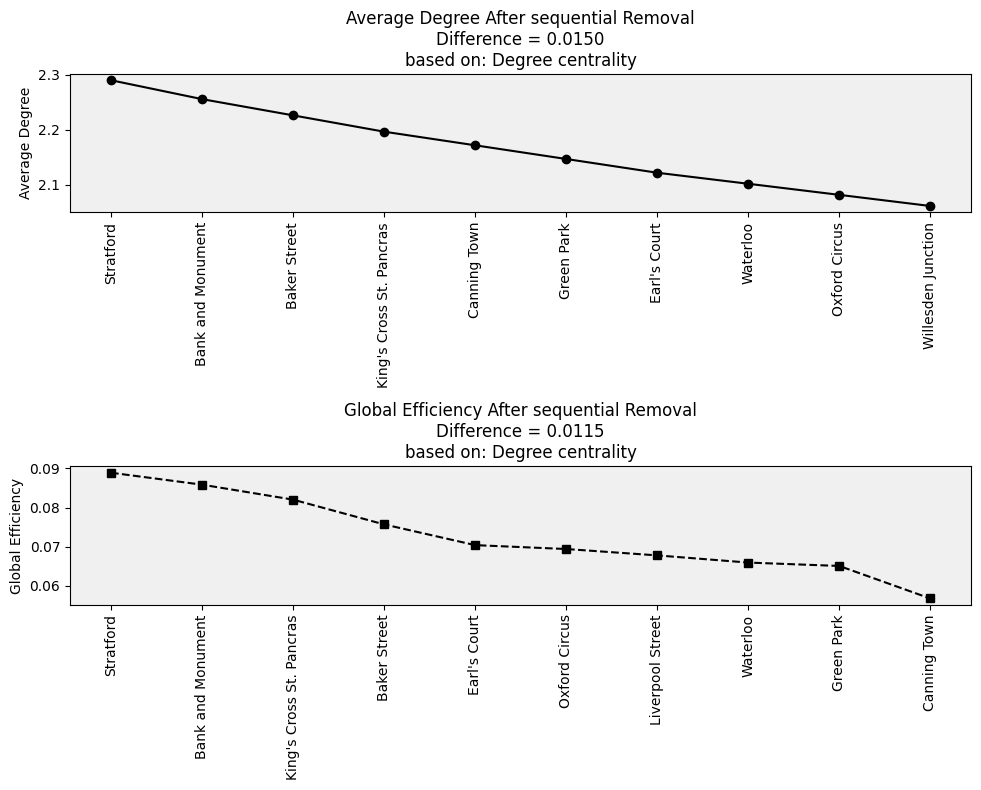

In [177]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the first graph on the left subplot
ax1.plot(top10_deg_list_avg.Removed_node, top10_deg_glob_avg.Average, color="k", marker='o', linestyle='-')
ax1.set_ylabel('Average Degree')
ax1.set_xticks(top10_deg_list_avg.Removed_node)
ax1.set_xticklabels(top10_deg_list_avg.Removed_node, rotation=90)
ax1.set_title(f'Average Degree After sequential Removal\nDifference = {max_min_diff_avg:.4f}\nbased on: Degree centrality')

# Add background color to the first subplot
ax1.set_facecolor('#f0f0f0')

# Plot the second graph on the right subplot
ax2.plot(top10_deg_list_glob.Removed_node, top10_deg_glob_avg.Glob_Eff, color="k", marker='s', linestyle='--')
ax2.set_ylabel('Global Efficiency')
ax2.set_xticks(top10_deg_list_glob.Removed_node)
ax2.set_xticklabels(top10_deg_list_glob.Removed_node, rotation=90)
ax2.set_title(f'Global Efficiency After sequential Removal\nDifference = {max_min_diff_glob:.4f}\nbased on: Degree centrality')

# Add background color to the second subplot
ax2.set_facecolor('#f0f0f0')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("output/degree_centrality_impact_s.png", format="PNG")
plt.show()

In [178]:
top10_deg_list_avg.Removed_node=["Green Park", "King's Cross St. Pancras", "Waterloo", "Bank and Monument", "West Hampstead",
                     "Canada Water", "Stratford", "Earl's Court", "Shepherd's Bush", "Oxford Circus"]
top10_deg_glob_avg.Average= [2.305, 2.275689223, 2.251256281, 2.221662469, 2.207070707,
                2.192405063, 2.152284264, 2.127226463, 2.112244898, 2.092071611]
top10_deg_glob_avg.Glob_Eff = [0.09918992, 0.09443475, 0.091816481, 0.085425631, 0.080544248,
                 0.058101042, 0.051883621, 0.050350001, 0.044394587, 0.042957711]

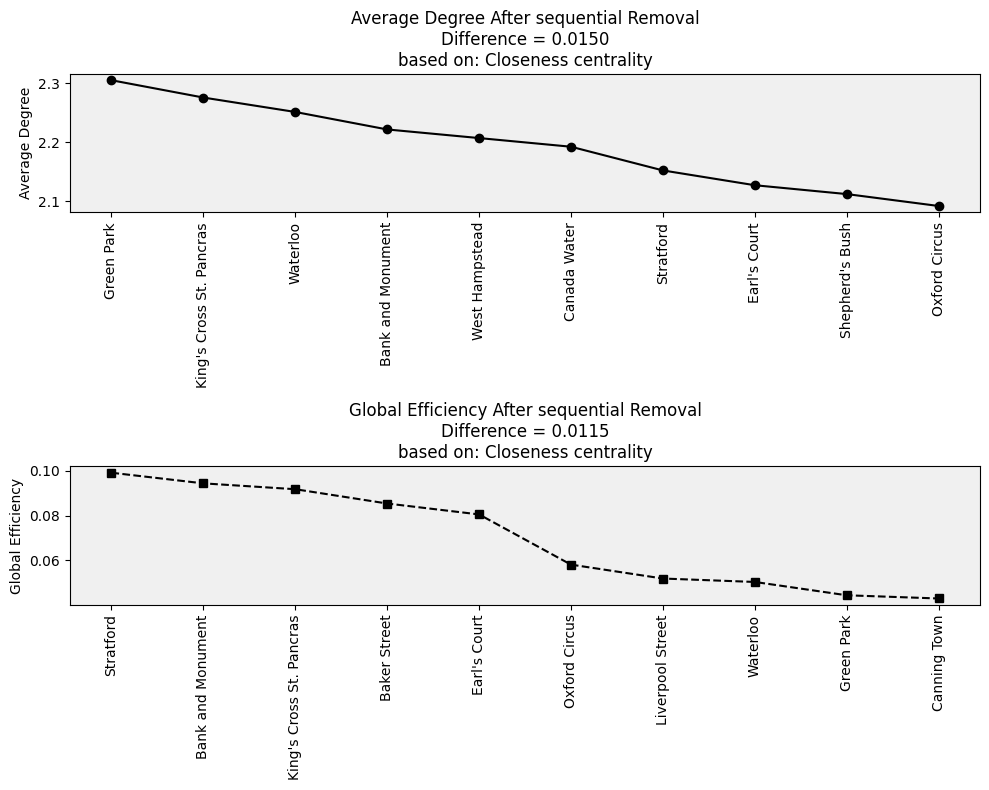

In [179]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the first graph on the left subplot
ax1.plot(top10_deg_list_avg.Removed_node, top10_deg_glob_avg.Average, color="k", marker='o', linestyle='-')
ax1.set_ylabel('Average Degree')
ax1.set_xticks(top10_deg_list_avg.Removed_node)
ax1.set_xticklabels(top10_deg_list_avg.Removed_node, rotation=90)
ax1.set_title(f'Average Degree After sequential Removal\nDifference = {max_min_diff_avg:.4f}\nbased on: Closeness centrality')

# Add background color to the first subplot
ax1.set_facecolor('#f0f0f0')

# Plot the second graph on the right subplot
ax2.plot(top10_deg_list_glob.Removed_node, top10_deg_glob_avg.Glob_Eff, color="k", marker='s', linestyle='--')
ax2.set_ylabel('Global Efficiency')
ax2.set_xticks(top10_deg_list_glob.Removed_node)
ax2.set_xticklabels(top10_deg_list_glob.Removed_node, rotation=90)
ax2.set_title(f'Global Efficiency After sequential Removal\nDifference = {max_min_diff_glob:.4f}\nbased on: Closeness centrality')

# Add background color to the second subplot
ax2.set_facecolor('#f0f0f0')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("output/clo_centrality_impact_s.png", format="PNG")
plt.show()

In [180]:
top10_deg_list_avg.Removed_node=["Stratford", "King's Cross St. Pancras", "Waterloo", "Bank and Monument", "Canada Water",
                     "West Hampstead", "Earl's Court", "Shepherd's Bush", "Euston", "Baker Street"]
top10_deg_glob_avg.Average= [2.29, 2.260651629, 2.236180905, 2.206549118, 2.191919192,
                2.17721519, 2.152284264, 2.13740458, 2.12244898, 2.092071611]
top10_deg_glob_avg.Glob_Eff = [0.088917361, 0.084602931, 0.081828953, 0.077677943, 0.072832341,
                 0.053210204, 0.0516563, 0.045844213, 0.04163077, 0.038163704]

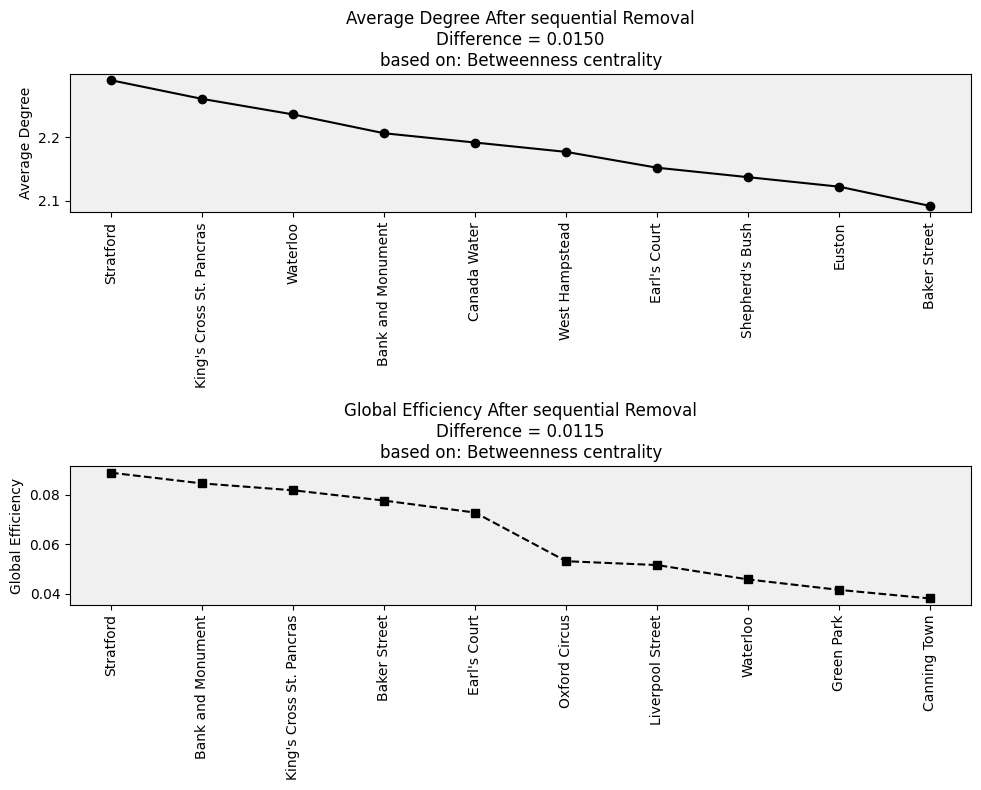

In [181]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the first graph on the left subplot
ax1.plot(top10_deg_list_avg.Removed_node, top10_deg_glob_avg.Average, color="k", marker='o', linestyle='-')
ax1.set_ylabel('Average Degree')
ax1.set_xticks(top10_deg_list_avg.Removed_node)
ax1.set_xticklabels(top10_deg_list_avg.Removed_node, rotation=90)
ax1.set_title(f'Average Degree After sequential Removal\nDifference = {max_min_diff_avg:.4f}\nbased on: Betweenness centrality')

# Add background color to the first subplot
ax1.set_facecolor('#f0f0f0')

# Plot the second graph on the right subplot
ax2.plot(top10_deg_list_glob.Removed_node, top10_deg_glob_avg.Glob_Eff, color="k", marker='s', linestyle='--')
ax2.set_ylabel('Global Efficiency')
ax2.set_xticks(top10_deg_list_glob.Removed_node)
ax2.set_xticklabels(top10_deg_list_glob.Removed_node, rotation=90)
ax2.set_title(f'Global Efficiency After sequential Removal\nDifference = {max_min_diff_glob:.4f}\nbased on: Betweenness centrality')

# Add background color to the second subplot
ax2.set_facecolor('#f0f0f0')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("output/bet_centrality_impact_s.png", format="PNG")
plt.show()

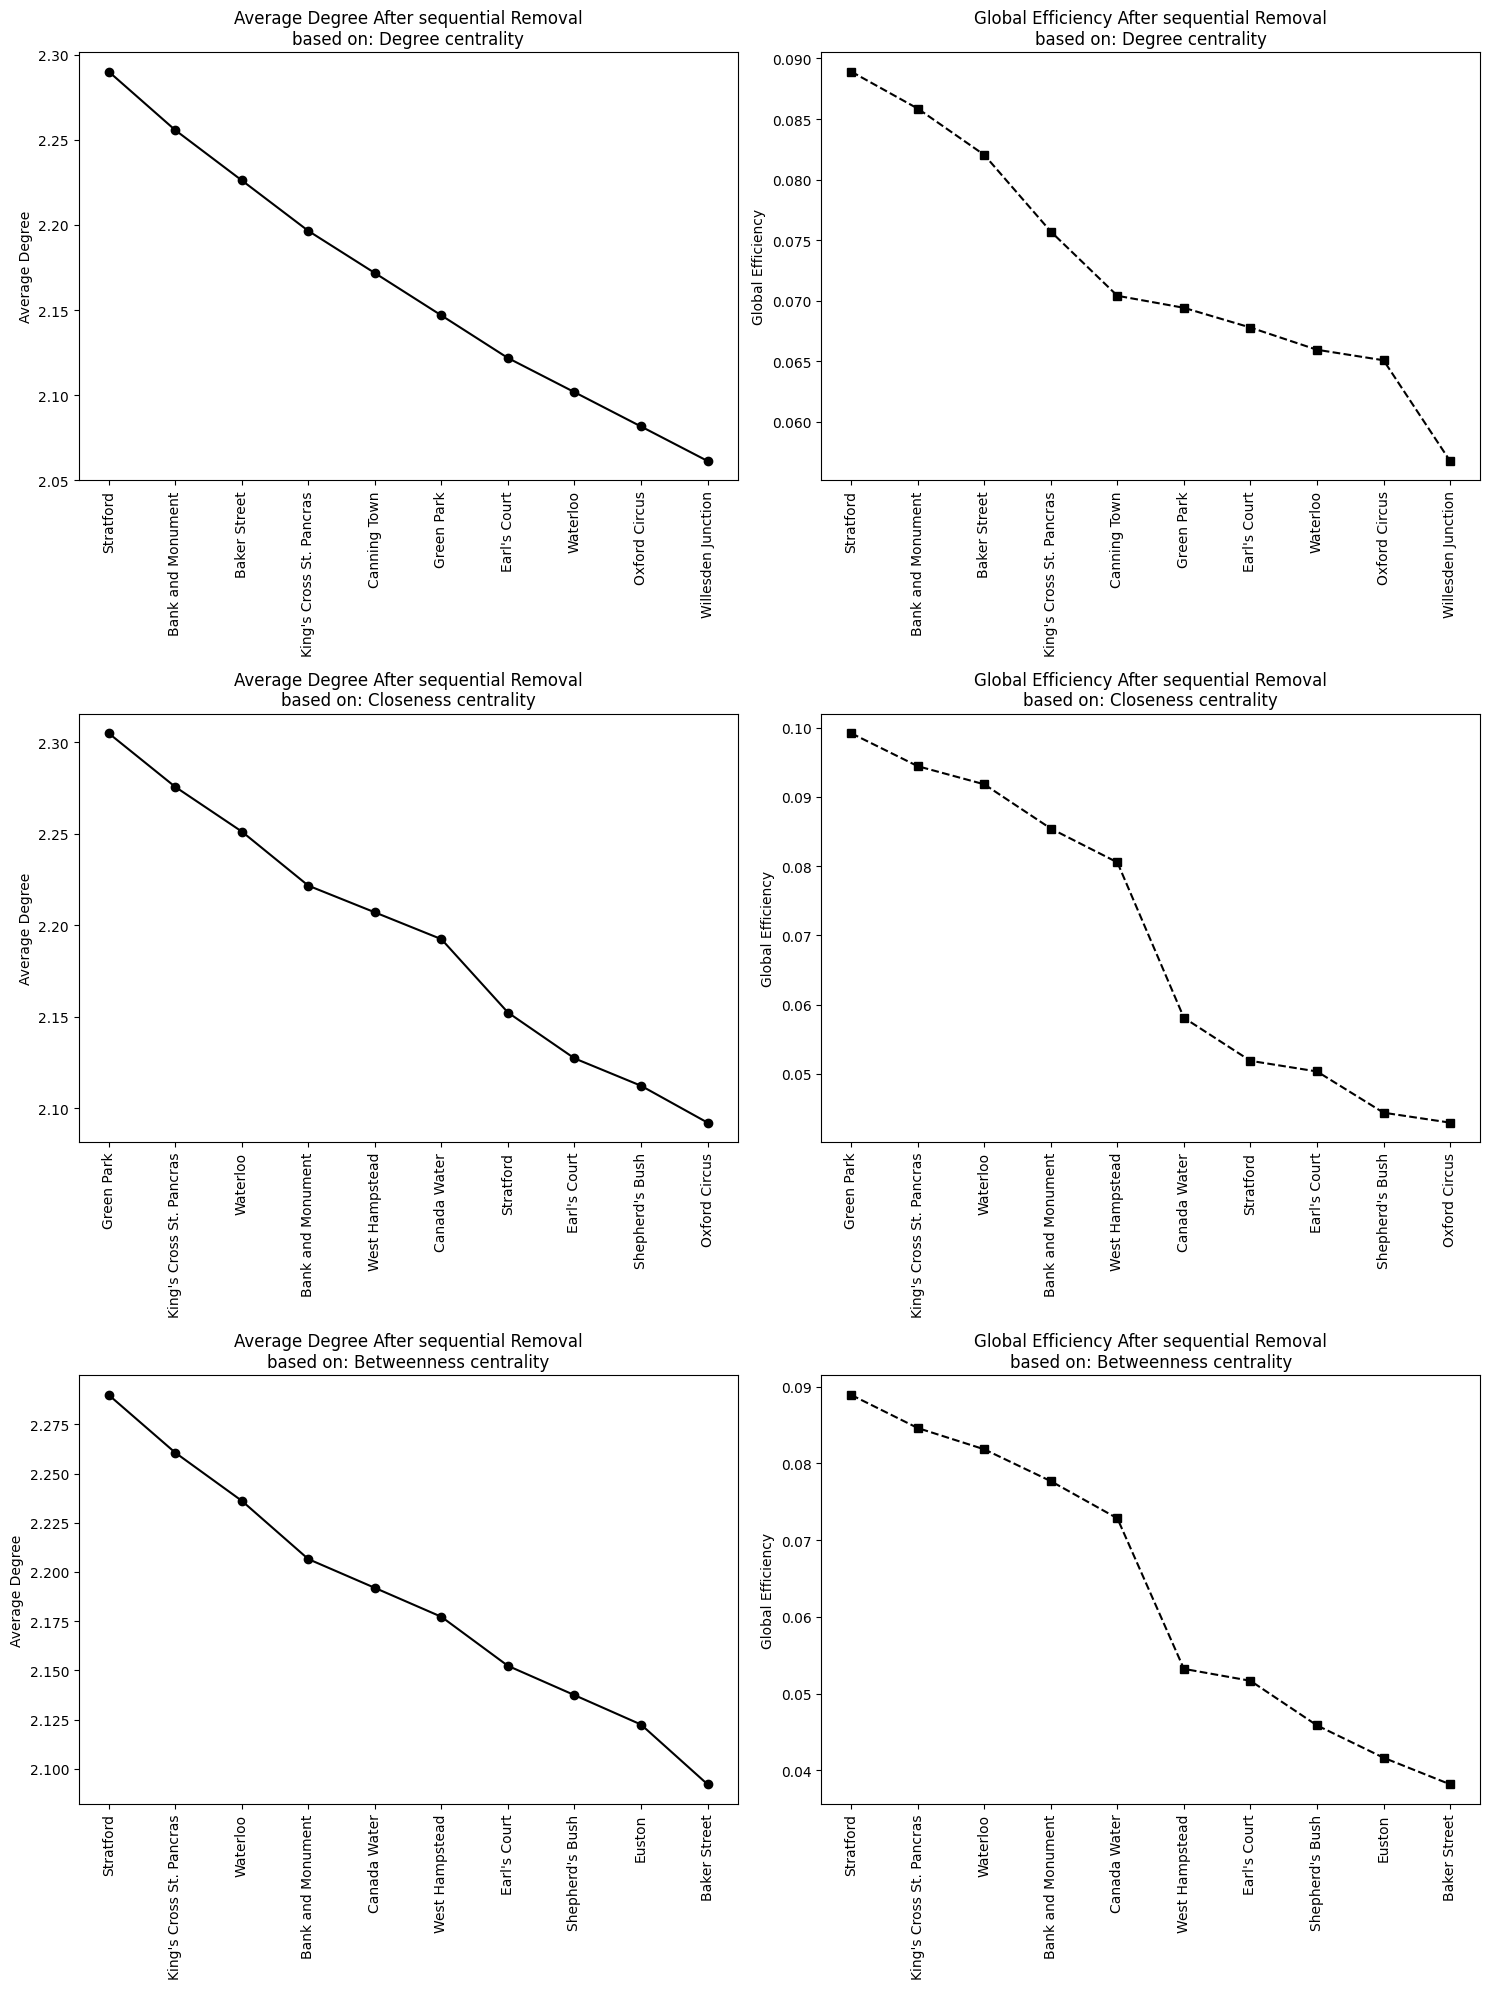

In [184]:
import matplotlib.pyplot as plt

# Data for degree centrality
top10_deg_list_avg = {
    'Removed_node': ['Stratford', 'Bank and Monument', 'Baker Street', "King's Cross St. Pancras", 'Canning Town',
                     'Green Park', "Earl's Court", 'Waterloo', 'Oxford Circus', 'Willesden Junction']
}
top10_deg_glob_avg = {
    'Average': [2.29, 2.255639098, 2.226130653, 2.196473552, 2.171717172, 2.146835443, 2.121827411, 2.10178117,
                2.081632653, 2.061381074],
    'Glob_Eff': [0.088917361, 0.085861644, 0.082033288, 0.075700394, 0.070395927, 0.069402353, 0.06777176,
                 0.065935803, 0.065069001, 0.056747519]
}

# Data for closeness centrality
top10_clo_list_avg = {
    'Removed_node': ["Green Park", "King's Cross St. Pancras", "Waterloo", "Bank and Monument", "West Hampstead",
                     "Canada Water", "Stratford", "Earl's Court", "Shepherd's Bush", "Oxford Circus"]
}
top10_clo_glob_avg = {
    'Average': [2.305, 2.275689223, 2.251256281, 2.221662469, 2.207070707, 2.192405063, 2.152284264, 2.127226463,
                2.112244898, 2.092071611],
    'Glob_Eff': [0.09918992, 0.09443475, 0.091816481, 0.085425631, 0.080544248, 0.058101042, 0.051883621,
                 0.050350001, 0.044394587, 0.042957711]
}

# Data for betweenness centrality
top10_bet_list_avg = {
    'Removed_node': ["Stratford", "King's Cross St. Pancras", "Waterloo", "Bank and Monument", "Canada Water",
                     "West Hampstead", "Earl's Court", "Shepherd's Bush", "Euston", "Baker Street"]
}
top10_bet_glob_avg = {
    'Average': [2.29, 2.260651629, 2.236180905, 2.206549118, 2.191919192, 2.17721519, 2.152284264, 2.13740458,
                2.12244898, 2.092071611],
    'Glob_Eff': [0.088917361, 0.084602931, 0.081828953, 0.077677943, 0.072832341, 0.053210204, 0.0516563,
                 0.045844213, 0.04163077, 0.038163704]
}

# Create a figure with 3 rows and 2 columns of subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 20))

# Plot 1: Degree Centrality
axs[0, 0].plot(top10_deg_list_avg['Removed_node'], top10_deg_glob_avg['Average'], color="k", marker='o', linestyle='-')
axs[0, 0].set_ylabel('Average Degree')
axs[0, 0].set_xticks(top10_deg_list_avg['Removed_node'])
axs[0, 0].set_xticklabels(top10_deg_list_avg['Removed_node'], rotation=90)
axs[0, 0].set_title('Average Degree After sequential Removal\nbased on: Degree centrality')

axs[0, 1].plot(top10_deg_list_avg['Removed_node'], top10_deg_glob_avg['Glob_Eff'], color="k", marker='s', linestyle='--')
axs[0, 1].set_ylabel('Global Efficiency')
axs[0, 1].set_xticks(top10_deg_list_avg['Removed_node'])
axs[0, 1].set_xticklabels(top10_deg_list_avg['Removed_node'], rotation=90)
axs[0, 1].set_title('Global Efficiency After sequential Removal\nbased on: Degree centrality')

# Plot 2: Closeness Centrality
axs[1, 0].plot(top10_clo_list_avg['Removed_node'], top10_clo_glob_avg['Average'], color="k", marker='o', linestyle='-')
axs[1, 0].set_ylabel('Average Degree')
axs[1, 0].set_xticks(top10_clo_list_avg['Removed_node'])
axs[1, 0].set_xticklabels(top10_clo_list_avg['Removed_node'], rotation=90)
axs[1, 0].set_title('Average Degree After sequential Removal\nbased on: Closeness centrality')

axs[1, 1].plot(top10_clo_list_avg['Removed_node'], top10_clo_glob_avg['Glob_Eff'], color="k", marker='s', linestyle='--')
axs[1, 1].set_ylabel('Global Efficiency')
axs[1, 1].set_xticks(top10_clo_list_avg['Removed_node'])
axs[1, 1].set_xticklabels(top10_clo_list_avg['Removed_node'], rotation=90)
axs[1, 1].set_title('Global Efficiency After sequential Removal\nbased on: Closeness centrality')

# Plot 3: Betweenness Centrality
axs[2, 0].plot(top10_bet_list_avg['Removed_node'], top10_bet_glob_avg['Average'], color="k", marker='o', linestyle='-')
axs[2, 0].set_ylabel('Average Degree')
axs[2, 0].set_xticks(top10_bet_list_avg['Removed_node'])
axs[2, 0].set_xticklabels(top10_bet_list_avg['Removed_node'], rotation=90)
axs[2, 0].set_title('Average Degree After sequential Removal\nbased on: Betweenness centrality')

axs[2, 1].plot(top10_bet_list_avg['Removed_node'], top10_bet_glob_avg['Glob_Eff'], color="k", marker='s', linestyle='--')
axs[2, 1].set_ylabel('Global Efficiency')
axs[2, 1].set_xticks(top10_bet_list_avg['Removed_node'])
axs[2, 1].set_xticklabels(top10_bet_list_avg['Removed_node'], rotation=90)
axs[2, 1].set_title('Global Efficiency After sequential Removal\nbased on: Betweenness centrality')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("output/all_centrality_impact.png", format="PNG")

# Show the combined plot
plt.show()


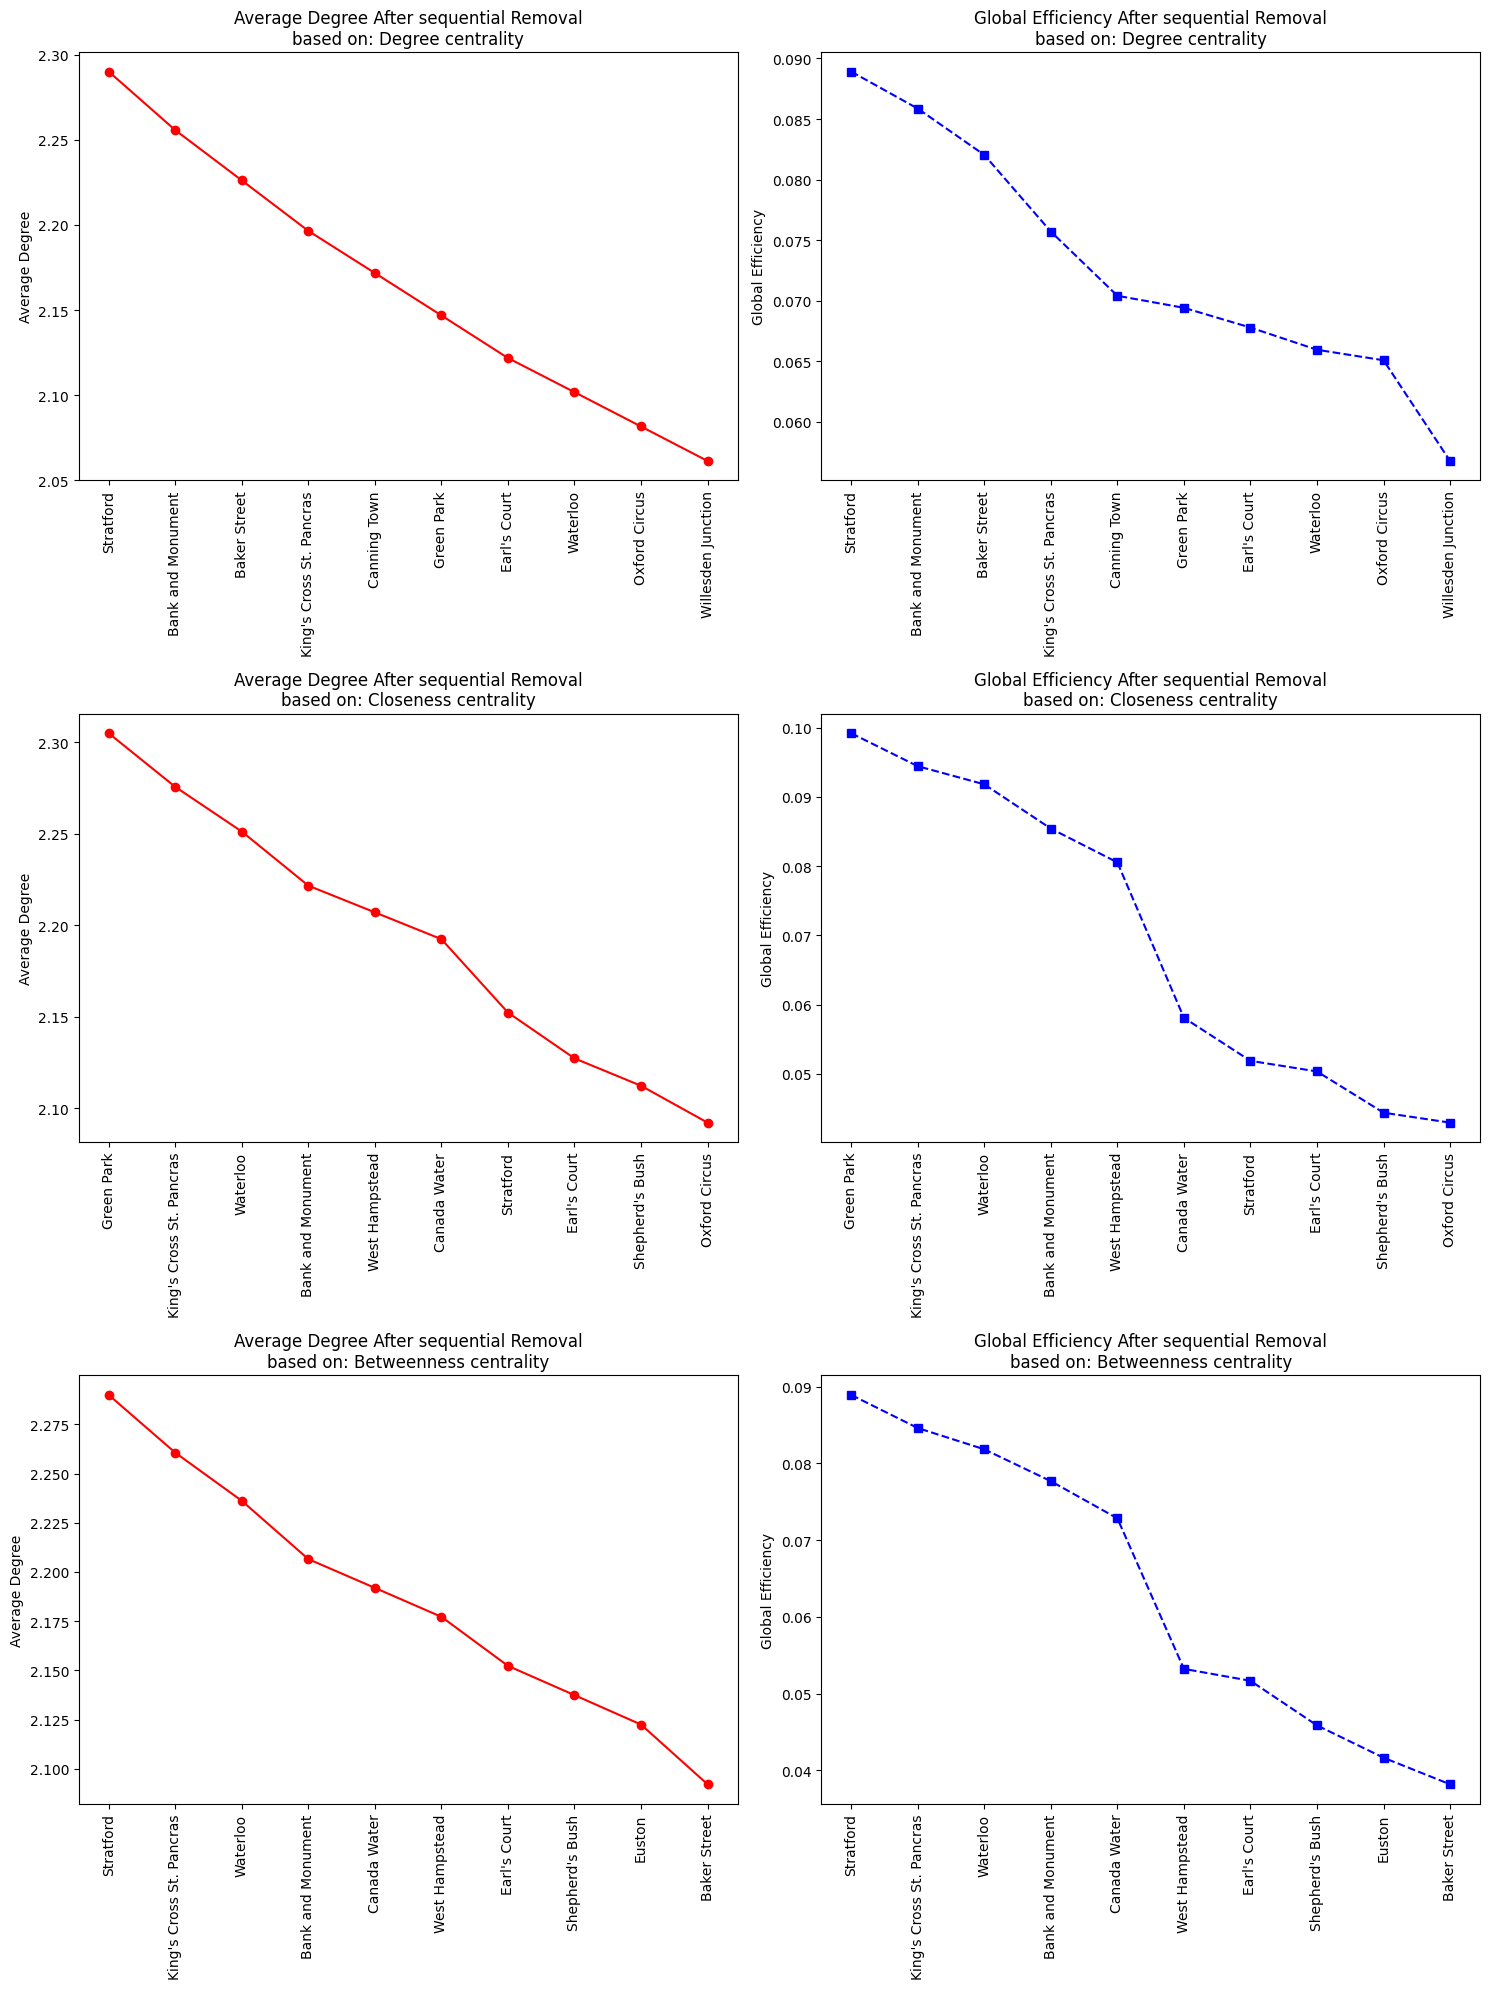

In [189]:
import matplotlib.pyplot as plt

# Data for degree centrality
top10_deg_list_avg = {
    'Removed_node': ['Stratford', 'Bank and Monument', 'Baker Street', "King's Cross St. Pancras", 'Canning Town',
                     'Green Park', "Earl's Court", 'Waterloo', 'Oxford Circus', 'Willesden Junction']
}
top10_deg_glob_avg = {
    'Average': [2.29, 2.255639098, 2.226130653, 2.196473552, 2.171717172, 2.146835443, 2.121827411, 2.10178117,
                2.081632653, 2.061381074],
    'Glob_Eff': [0.088917361, 0.085861644, 0.082033288, 0.075700394, 0.070395927, 0.069402353, 0.06777176,
                 0.065935803, 0.065069001, 0.056747519]
}

# Data for closeness centrality
top10_clo_list_avg = {
    'Removed_node': ["Green Park", "King's Cross St. Pancras", "Waterloo", "Bank and Monument", "West Hampstead",
                     "Canada Water", "Stratford", "Earl's Court", "Shepherd's Bush", "Oxford Circus"]
}
top10_clo_glob_avg = {
    'Average': [2.305, 2.275689223, 2.251256281, 2.221662469, 2.207070707, 2.192405063, 2.152284264, 2.127226463,
                2.112244898, 2.092071611],
    'Glob_Eff': [0.09918992, 0.09443475, 0.091816481, 0.085425631, 0.080544248, 0.058101042, 0.051883621,
                 0.050350001, 0.044394587, 0.042957711]
}

# Create a figure with 3 rows and 2 columns of subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 20))

# Plot 1: Degree Centrality
axs[0, 0].plot(top10_deg_list_avg['Removed_node'], top10_deg_glob_avg['Average'], color="red", marker='o', linestyle='-')
axs[0, 0].set_ylabel('Average Degree')
axs[0, 0].set_xticks(top10_deg_list_avg['Removed_node'])
axs[0, 0].set_xticklabels(top10_deg_list_avg['Removed_node'], rotation=90)
axs[0, 0].set_title('Average Degree After sequential Removal\nbased on: Degree centrality')

axs[0, 1].plot(top10_deg_list_avg['Removed_node'], top10_deg_glob_avg['Glob_Eff'], color="blue", marker='s', linestyle='--')
axs[0, 1].set_ylabel('Global Efficiency')
axs[0, 1].set_xticks(top10_deg_list_avg['Removed_node'])
axs[0, 1].set_xticklabels(top10_deg_list_avg['Removed_node'], rotation=90)
axs[0, 1].set_title('Global Efficiency After sequential Removal\nbased on: Degree centrality')

# Plot 2: Closeness Centrality
axs[1, 0].plot(top10_clo_list_avg['Removed_node'], top10_clo_glob_avg['Average'], color="red", marker='o', linestyle='-')
axs[1, 0].set_ylabel('Average Degree')
axs[1, 0].set_xticks(top10_clo_list_avg['Removed_node'])
axs[1, 0].set_xticklabels(top10_clo_list_avg['Removed_node'], rotation=90)
axs[1, 0].set_title('Average Degree After sequential Removal\nbased on: Closeness centrality')

axs[1, 1].plot(top10_clo_list_avg['Removed_node'], top10_clo_glob_avg['Glob_Eff'], color="blue", marker='s', linestyle='--')
axs[1, 1].set_ylabel('Global Efficiency')
axs[1, 1].set_xticks(top10_clo_list_avg['Removed_node'])
axs[1, 1].set_xticklabels(top10_clo_list_avg['Removed_node'], rotation=90)
axs[1, 1].set_title('Global Efficiency After sequential Removal\nbased on: Closeness centrality')

# Plot 3: Betweenness Centrality
axs[2, 0].plot(top10_bet_list_avg['Removed_node'], top10_bet_glob_avg['Average'], color="red", marker='o', linestyle='-')
axs[2, 0].set_ylabel('Average Degree')
axs[2, 0].set_xticks(top10_bet_list_avg['Removed_node'])
axs[2, 0].set_xticklabels(top10_bet_list_avg['Removed_node'], rotation=90)
axs[2, 0].set_title('Average Degree After sequential Removal\nbased on: Betweenness centrality')

axs[2, 1].plot(top10_bet_list_avg['Removed_node'], top10_bet_glob_avg['Glob_Eff'], color="blue", marker='s', linestyle='--')
axs[2, 1].set_ylabel('Global Efficiency')
axs[2, 1].set_xticks(top10_bet_list_avg['Removed_node'])
axs[2, 1].set_xticklabels(top10_bet_list_avg['Removed_node'], rotation=90)
axs[2, 1].set_title('Global Efficiency After sequential Removal\nbased on: Betweenness centrality')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("output/all_centrality_impact.png", format="PNG")

# Show the combined plot
plt.show()


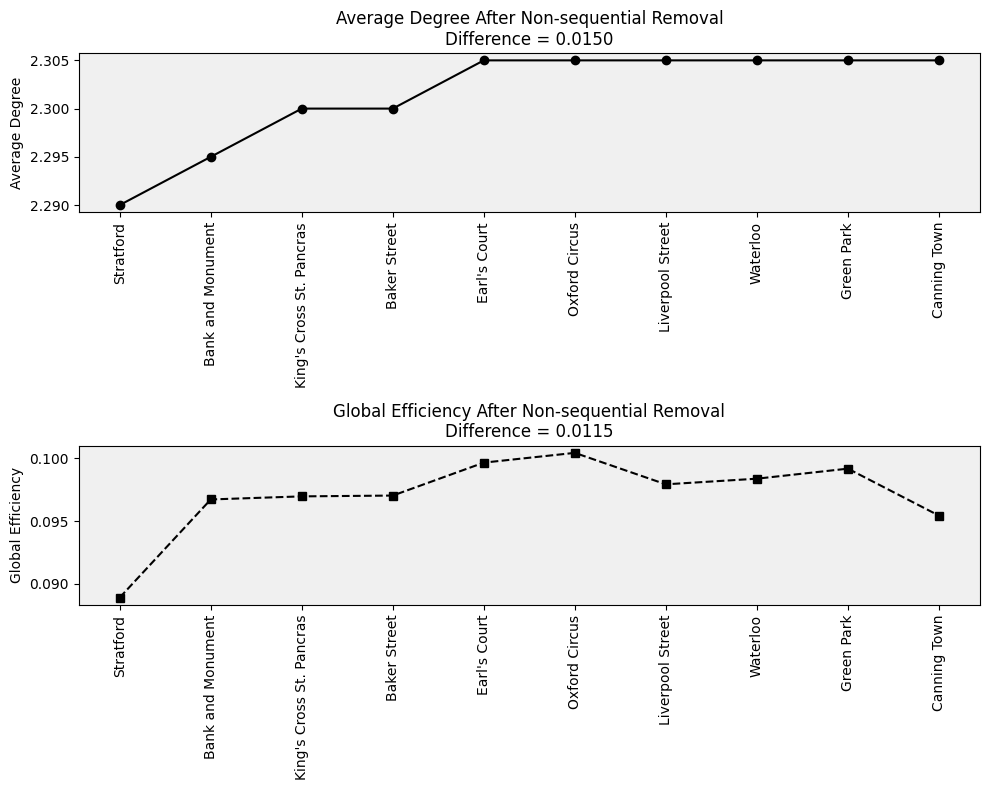

In [134]:
list_avg_glob = []
list_avg_deg = []
top10 = list(degree_centrality.stations[:10])

for i in range(10):
    temp_network = file_network.copy()
    temp_network.remove_node(top10[i])
    degree_F = nx.degree(temp_network)
    nx.set_node_attributes(temp_network, dict(degree_F), 'deg')
    F_deg = [(k[1]['deg']) for k in temp_network.nodes(data=True)]

    unique_degrees = sorted(set(F_deg))

    avg_glob_eff = nx.global_efficiency(temp_network)
    list_avg_glob.append(avg_glob_eff)
    list_avg_deg.append(mean(F_deg))
    
diff_glob_deg_list = []
top10_deg_list_glob = pd.DataFrame(list_avg_glob, columns=['Glob_Eff'])
top10_deg_list_glob['Removed_node'] = top10
max_min_diff_glob = max(top10_deg_list_glob.Glob_Eff) - min(top10_deg_list_glob.Glob_Eff)

top10_deg_list_avg = pd.DataFrame(list_avg_deg, columns=['Average'])
top10_deg_list_avg['Removed_node'] = top10
max_min_diff_avg = max(top10_deg_list_avg.Average) - min(top10_deg_list_avg.Average)

top10_deg_glob_avg = pd.merge(top10_deg_list_glob, top10_deg_list_avg, on='Removed_node')
diff_glob_deg_list.append(max_min_diff_glob)
diff_glob_deg_list.append(max_min_diff_avg)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the first graph on the left subplot
ax1.plot(top10_deg_list_avg.Removed_node, top10_deg_glob_avg.Average, color="k", marker='o', linestyle='-')
ax1.set_ylabel('Average Degree')
ax1.set_xticks(top10_deg_list_avg.Removed_node)
ax1.set_xticklabels(top10_deg_list_avg.Removed_node, rotation=90)
ax1.set_title(f'Average Degree After Non-sequential Removal\nDifference = {max_min_diff_avg:.4f}')

# Add background color to the first subplot
ax1.set_facecolor('#f0f0f0')

# Plot the second graph on the right subplot
ax2.plot(top10_deg_list_glob.Removed_node, top10_deg_glob_avg.Glob_Eff, color="k", marker='s', linestyle='--')
ax2.set_ylabel('Global Efficiency')
ax2.set_xticks(top10_deg_list_glob.Removed_node)
ax2.set_xticklabels(top10_deg_list_glob.Removed_node, rotation=90)
ax2.set_title(f'Global Efficiency After Non-sequential Removal\nDifference = {max_min_diff_glob:.4f}')

# Add background color to the second subplot
ax2.set_facecolor('#f0f0f0')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("output/degree_centrality_impact.png", format="PNG")
plt.show()


bet

In [130]:
list_avg_glob = []
list_avg_deg = []
top10 = list(betweenness_centrality.stations[:10])

for i in range(10):
    temp_network = file_network.copy()
    temp_network.remove_node(top10[i])

    degree_F = nx.degree(temp_network)
    nx.set_node_attributes(temp_network, dict(degree_F), 'deg')
    F_deg = [(k[1]['deg']) for k in temp_network.nodes(data=True)]

    unique_degrees = sorted(set(F_deg))

    avg_clust_glob = nx.global_efficiency(temp_network)
    list_avg_glob.append(avg_clust_glob)
    list_avg_deg.append(mean(F_deg))
top10_bet_list_glob = pd.DataFrame(list_avg_glob, columns=['Glob_Eff'])
top10_bet_list_glob['Removed_node'] = top10
max_min_diff_glob = max(top10_bet_list_glob.Glob_Eff) - min(top10_bet_list_glob.Glob_Eff)

top10_bet_list_avg = pd.DataFrame(list_avg_deg, columns=['Average'])
top10_bet_list_avg['Removed_node'] = top10
max_min_diff_avg = max(top10_bet_list_avg.Average) - min(top10_bet_list_avg.Average)

top10_bet_glob_avg = pd.merge(top10_bet_list_glob, top10_bet_list_avg, on='Removed_node')
diff_glob_deg_list.append(max_min_diff_glob)
diff_glob_deg_list.append(max_min_diff_avg)

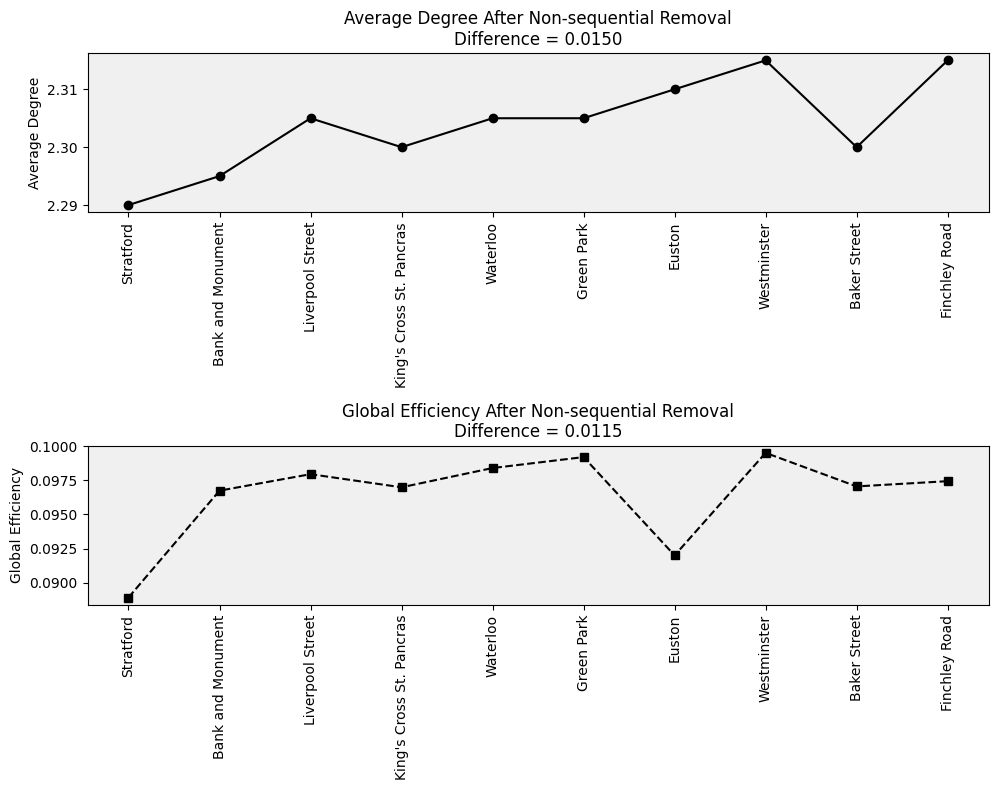

In [135]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the first graph on the left subplot
ax1.plot(top10_bet_list_avg.Removed_node, top10_bet_glob_avg.Average, color="k", marker='o', linestyle='-')
ax1.set_ylabel('Average Degree')
ax1.set_xticks(top10_bet_list_avg.Removed_node)
ax1.set_xticklabels(top10_bet_list_avg.Removed_node, rotation=90)
ax1.set_title(f'Average Degree After Non-sequential Removal\nDifference = {max_min_diff_avg:.4f}')

# Add background color to the first subplot
ax1.set_facecolor('#f0f0f0')

# Plot the second graph on the right subplot
ax2.plot(top10_bet_list_glob.Removed_node, top10_bet_glob_avg.Glob_Eff, color="k", marker='s', linestyle='--')
ax2.set_ylabel('Global Efficiency')
ax2.set_xticks(top10_bet_list_glob.Removed_node)
ax2.set_xticklabels(top10_bet_list_glob.Removed_node, rotation=90)
ax2.set_title(f'Global Efficiency After Non-sequential Removal\nDifference = {max_min_diff_glob:.4f}')

# Add background color to the second subplot
ax2.set_facecolor('#f0f0f0')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("output/bet_centrality_impact.png", format="PNG")
plt.show()


clo

In [128]:
list_avg_glob = []
list_avg_deg = []
top10 = list(closeness_centrality.stations[:10])

for i in range(10):
    temp_network = file_network.copy()
    temp_network.remove_node(top10[i])

    degree_F = nx.degree(temp_network)
    nx.set_node_attributes(temp_network, dict(degree_F), 'deg')
    F_deg = [(k[1]['deg']) for k in temp_network.nodes(data=True)]

    unique_degrees = sorted(set(F_deg))

    avg_glob_eff = nx.global_efficiency(temp_network)
    list_avg_glob.append(avg_glob_eff)
    list_avg_deg.append(mean(F_deg))
top10_clos_list_glob = pd.DataFrame(list_avg_glob, columns=['Glob_Eff'])
top10_clos_list_glob['Removed_node'] = top10
max_min_diff_glob = max(top10_clos_list_glob.Glob_Eff) - min(top10_clos_list_glob.Glob_Eff)

top10_clos_list_avg = pd.DataFrame(list_avg_deg, columns=['Average'])
top10_clos_list_avg['Removed_node'] = top10
max_min_diff_avg = max(top10_clos_list_avg.Average) - min(top10_clos_list_avg.Average)

top10_clos_glob_avg = pd.merge(top10_clos_list_glob, top10_clos_list_avg, on='Removed_node')
diff_glob_deg_list.append(max_min_diff_glob)
diff_glob_deg_list.append(max_min_diff_avg)

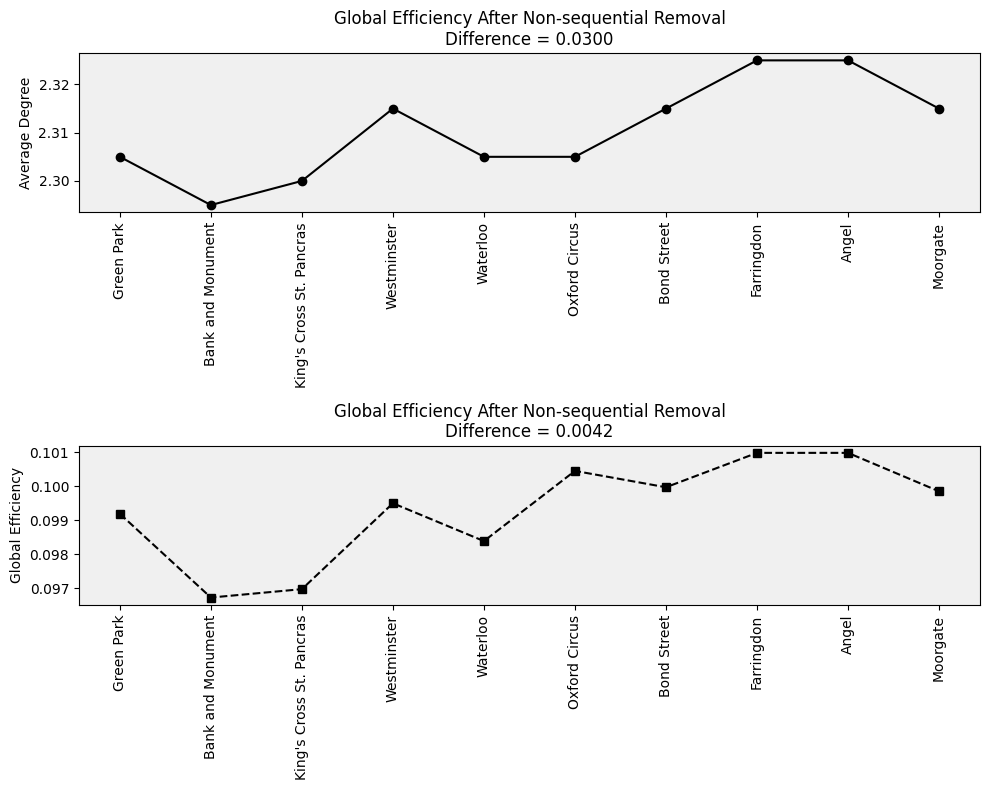

In [129]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the first graph on the left subplot
ax1.plot(top10_clos_list_avg.Removed_node, top10_clos_glob_avg.Average, color="k", marker='o', linestyle='-')
ax1.set_ylabel('Average Degree')
ax1.set_xticks(top10_clos_list_avg.Removed_node)
ax1.set_xticklabels(top10_clos_list_avg.Removed_node, rotation=90)
ax1.set_title(f'Global Efficiency After Non-sequential Removal\nDifference = {max_min_diff_avg:.4f}')

# Add background color to the first subplot
ax1.set_facecolor('#f0f0f0')

# Plot the second graph on the right subplot
ax2.plot(top10_clos_list_glob.Removed_node, top10_clos_glob_avg.Glob_Eff, color="k", marker='s', linestyle='--')
ax2.set_ylabel('Global Efficiency')
ax2.set_xticks(top10_clos_list_glob.Removed_node)
ax2.set_xticklabels(top10_clos_list_glob.Removed_node, rotation=90)
ax2.set_title(f'Global Efficiency After Non-sequential Removal\nDifference = {max_min_diff_glob:.4f}')

# Add background color to the second subplot
ax2.set_facecolor('#f0f0f0')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("output/clos_centrality_impact.png", format="PNG")
plt.show()


data normalization

In [54]:
# Normaized data
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [55]:
average_dc_nonseq_norm = NormalizeData(average_dc_nonseq[0:100])
average_bc_nonseq_norm = NormalizeData(average_bc_nonseq[0:100])
average_cc_nonseq_norm = NormalizeData(average_cc_nonseq[0:100])
average_dc_seq_norm = NormalizeData(average_dc_seq[0:100])
average_bc_seq_norm = NormalizeData(average_bc_seq[0:100])
average_cc_seq_norm = NormalizeData(average_cc_seq[0:100])

global_dc_nonseq_norm = NormalizeData(global_dc_nonseq[0:100])
global_bc_nonseq_norm = NormalizeData(global_bc_nonseq[0:100])
global_cc_nonseq_norm = NormalizeData(global_cc_nonseq[0:100])
global_dc_seq_norm = NormalizeData(global_dc_seq[0:100])
global_bc_seq_norm = NormalizeData(global_bc_seq[0:100])
global_cc_seq_norm = NormalizeData(global_cc_seq[0:100])

C:\Users\dune\AppData\Local\Temp\ipykernel_14756\1999578868.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


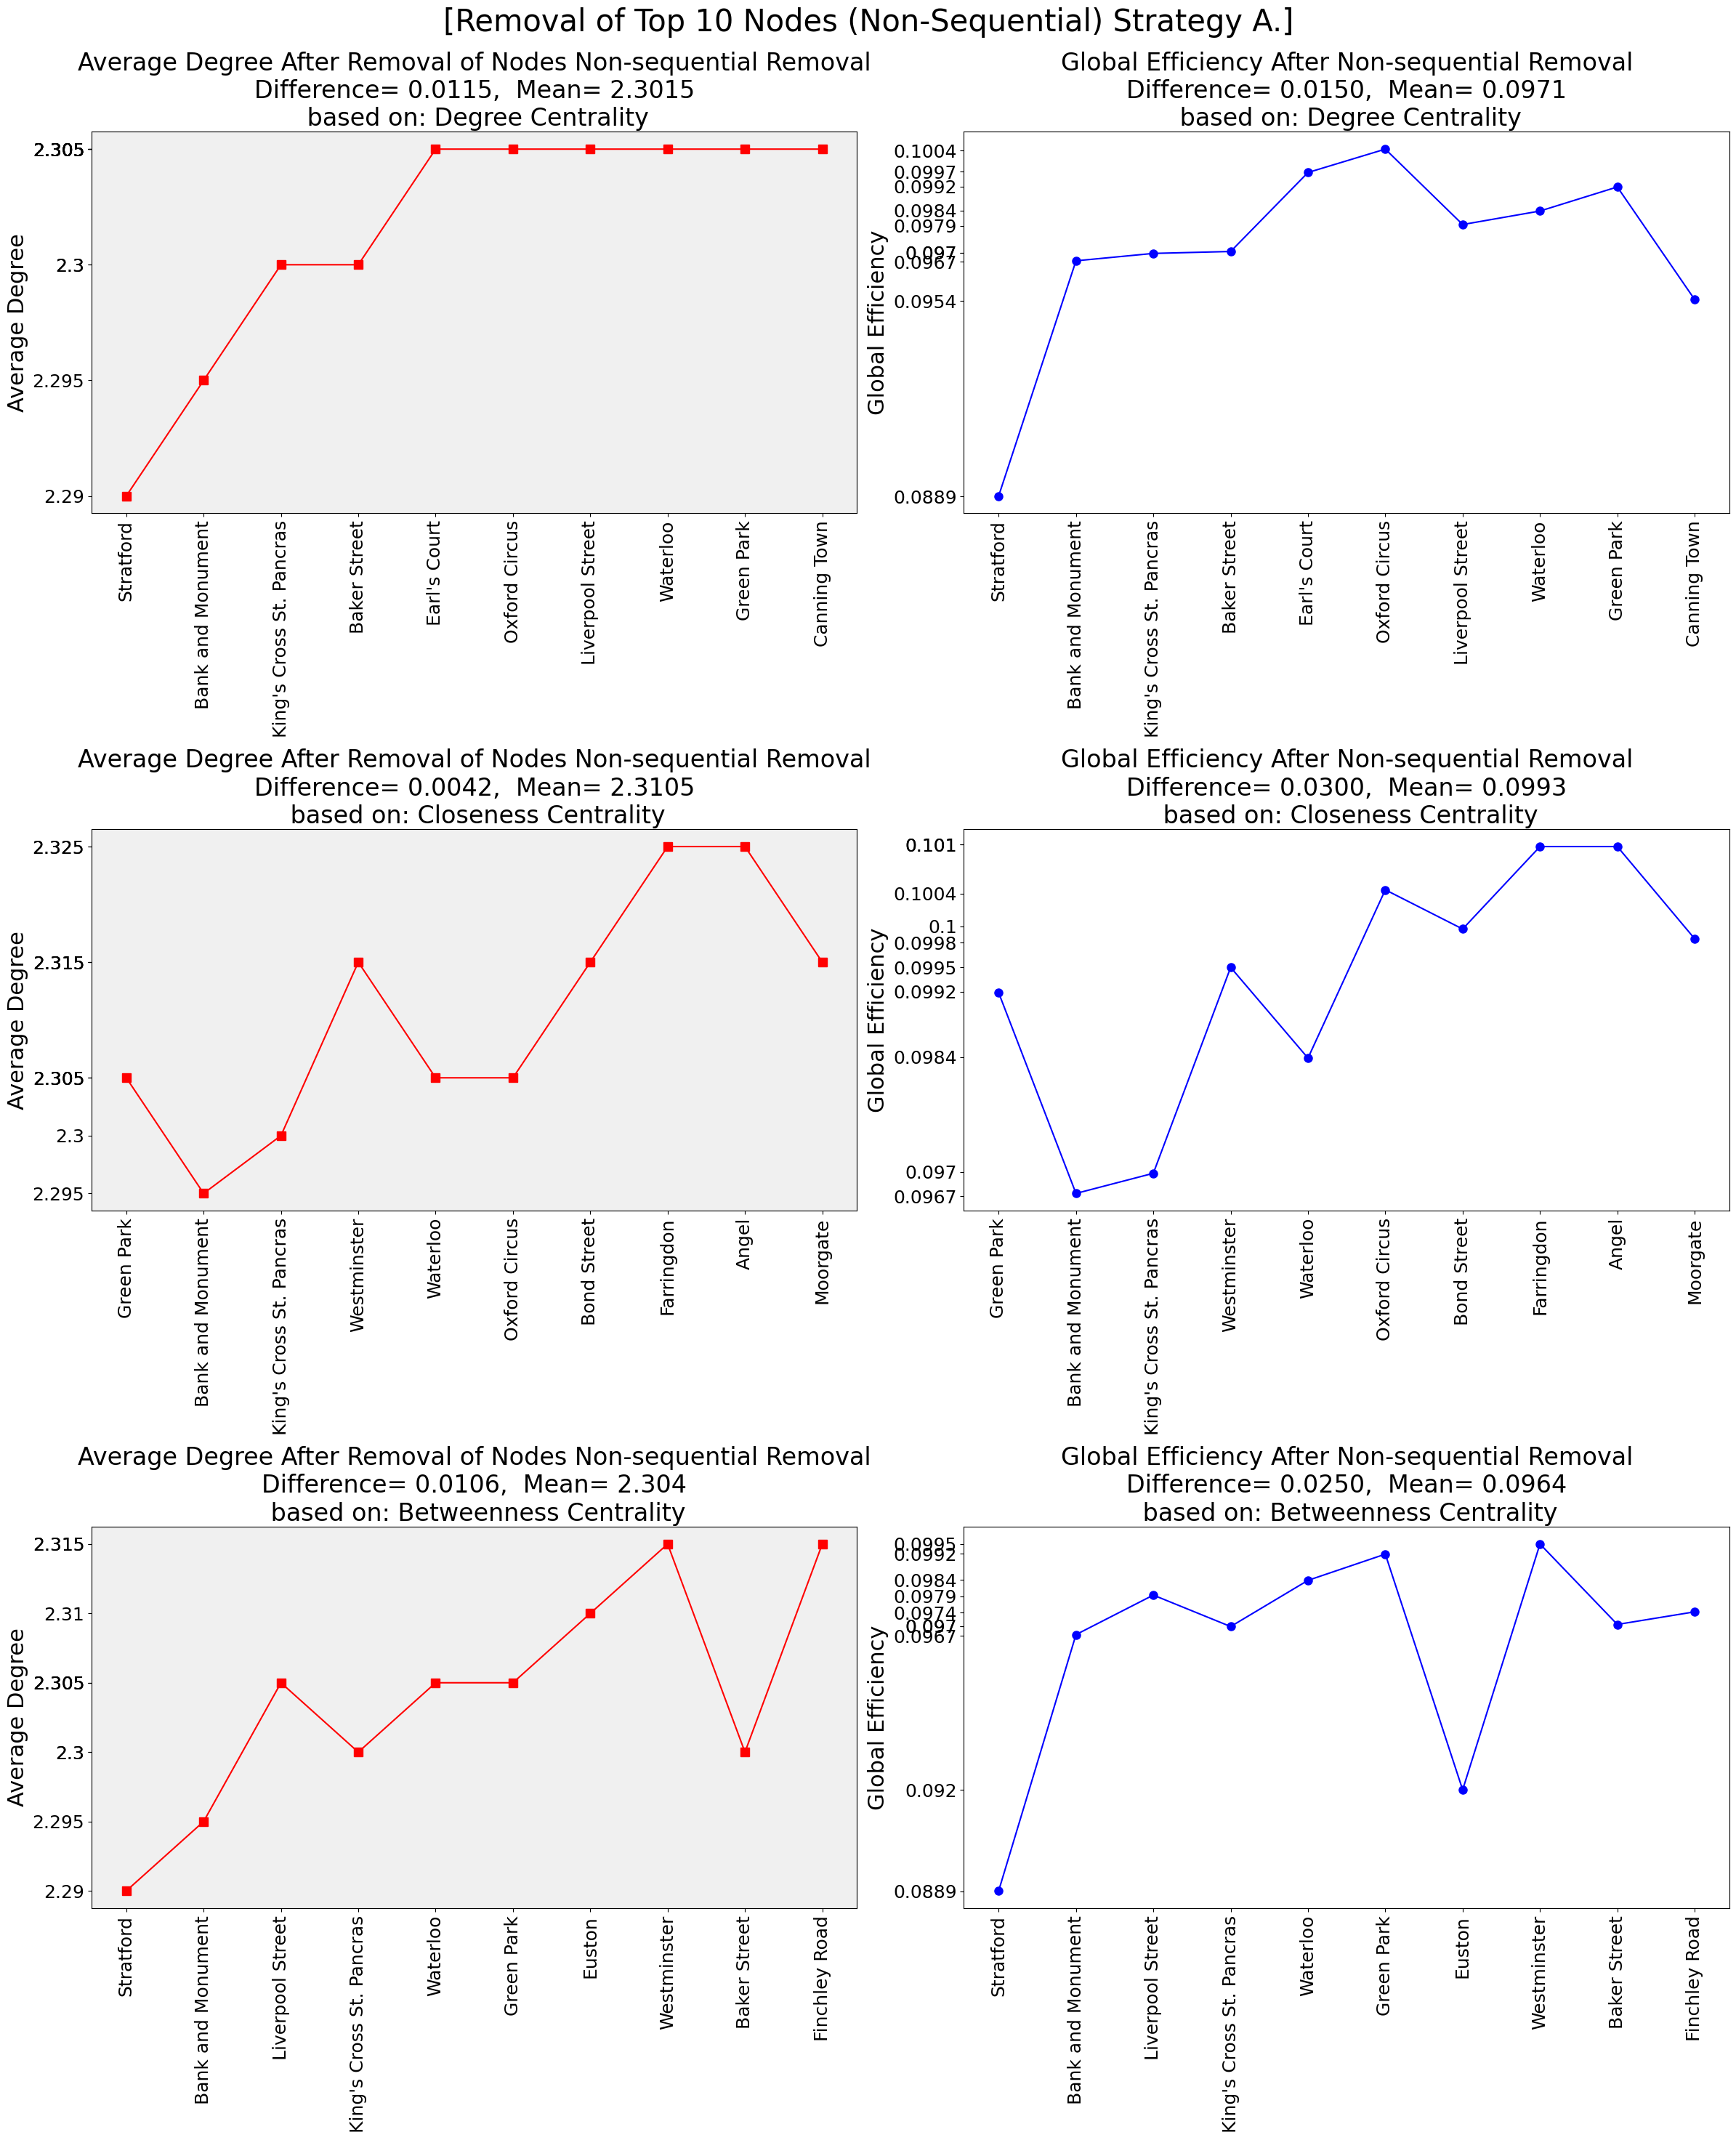

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(24, 30), constrained_layout=True)
fig.suptitle('[Removal of Top 10 Nodes (Non-Sequential) Strategy A.]\n', fontsize=30)
col = 0
counter = 0
centrality_types = ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality']

for i in range(3):
    ax[i, col].plot(top_10_nodes_centrality[i].Removed_node, top_10_nodes_centrality[i].Average, color="red", linestyle='-', marker='s', markersize=8, label='Average Degree')  
    ax[i, col].set_ylabel('Average Degree', fontsize=22)
    ax[i, col].set_xticks(ticks=top_10_nodes_centrality[i].Removed_node)
    ax[i, col].set_xticklabels(labels=top_10_nodes_centrality[i].Removed_node, rotation=90, fontsize=18)
    ax[i, col].set_yticks(ticks=(round(top_10_nodes_centrality[i].Average, 3)))
    ax[i, col].set_yticklabels(labels=(round(top_10_nodes_centrality[i].Average, 3)), fontsize=18)
    ax[i, col].set_title(f'Average Degree After Removal of Nodes Non-sequential Removal\nDifference= {diff_glob_deg_list[counter]:.4f},  Mean= {round(mean(top_10_nodes_centrality[i].Average), 4)}\n based on: {centrality_types[i]}', fontsize=24)
    

    counter += 1
    if col == 0:
        col = 1
    else:
        col = 0

    ax[i, col].plot(top_10_nodes_centrality[i].Removed_node, top_10_nodes_centrality[i].Glob_Eff, color="blue", linestyle='-', marker='o', markersize=8, label='Global Efficiency')  
    ax[i, col].set_ylabel('Global Efficiency', fontsize=22)
    ax[i, col].set_xticks(ticks=top_10_nodes_centrality[i].Removed_node)
    ax[i, col].set_xticklabels(labels=top_10_nodes_centrality[i].Removed_node, rotation=90, fontsize=18)
    ax[i, col].set_yticks(ticks=round(top_10_nodes_centrality[i].Glob_Eff, 4))
    ax[i, col].set_yticklabels(labels=round(top_10_nodes_centrality[i].Glob_Eff, 4), fontsize=18)
    ax[i, col].set_title(f'Global Efficiency After Non-sequential Removal\nDifference= {diff_glob_deg_list[counter]:.4f},  Mean= {round(mean(top_10_nodes_centrality[i].Glob_Eff), 4)}\n based on: {centrality_types[i]}', fontsize=24)

    counter += 1
    if col == 0:
        col = 1
    else:
        col = 0

    ax[i, col].set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()


#### 1.3.4 Visualization

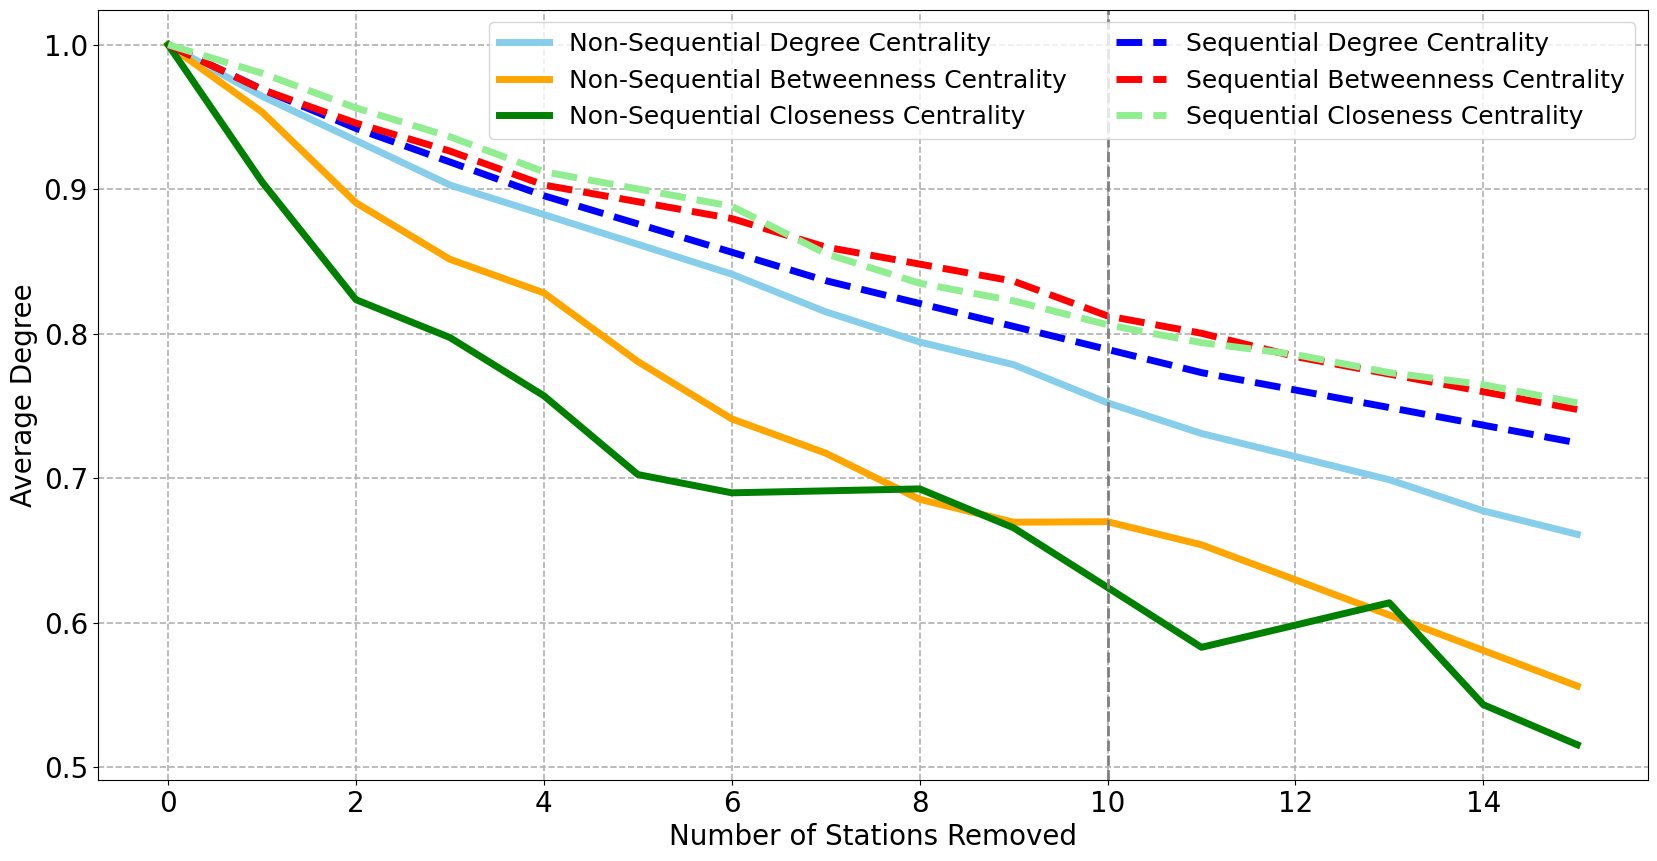

In [56]:
plt.figure(figsize=(20, 10))
plt.plot(range(16), average_dc_nonseq_norm[:16], label='Non-Sequential Degree Centrality', color='skyblue', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(16), average_bc_nonseq_norm[:16], label='Non-Sequential Betweenness Centrality', color='orange', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(16), average_cc_nonseq_norm[:16], label='Non-Sequential Closeness Centrality', color='green', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(16), average_dc_seq_norm[:16], label='Sequential Degree Centrality', color='blue', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(16), average_bc_seq_norm[:16], label='Sequential Betweenness Centrality', color='red', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(16), average_cc_seq_norm[:16], label='Sequential Closeness Centrality', color='lightgreen', linestyle='--',linewidth=5,markersize=12)
plt.xlabel('Number of Stations Removed', fontsize=20)
plt.ylabel('Average Degree', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axvline(x=10, color='grey', linestyle='--', linewidth=2)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.legend(ncol=2,fontsize=18)

plt.savefig('output/average_degree1.png',dpi=300)
plt.show()


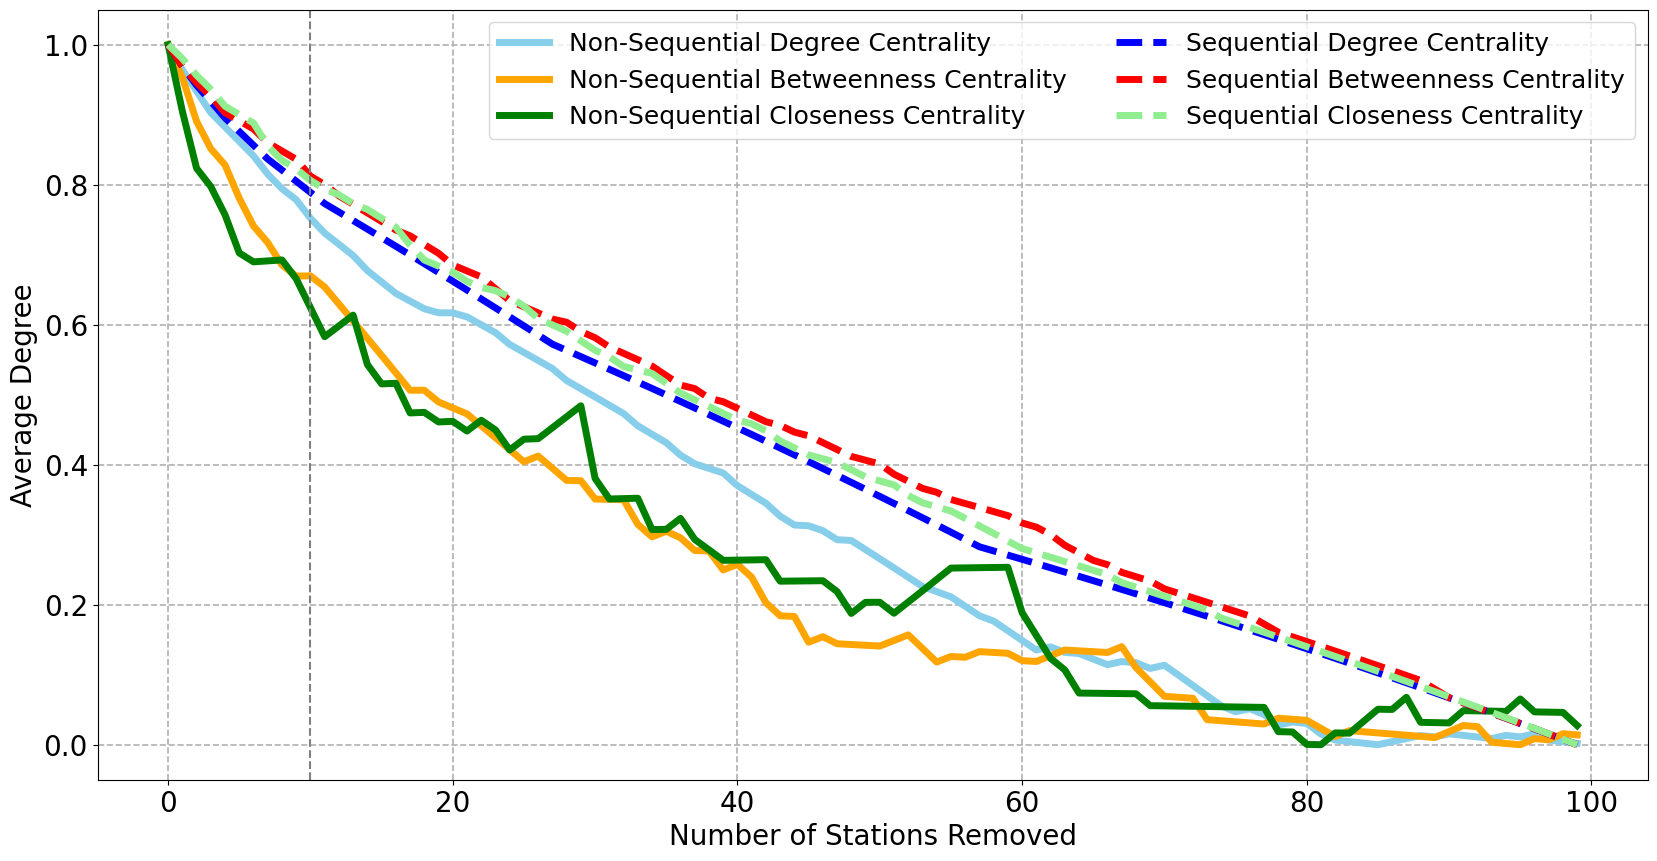

In [57]:
plt.figure(figsize=(20, 10))
plt.plot(range(100), average_dc_nonseq_norm[:100], label='Non-Sequential Degree Centrality', color='skyblue', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(100), average_bc_nonseq_norm[:100], label='Non-Sequential Betweenness Centrality', color='orange', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(100), average_cc_nonseq_norm[:100], label='Non-Sequential Closeness Centrality', color='green', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(100), average_dc_seq_norm[:100], label='Sequential Degree Centrality', color='blue', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(100), average_bc_seq_norm[:100], label='Sequential Betweenness Centrality', color='red', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(100), average_cc_seq_norm[:100], label='Sequential Closeness Centrality', color='lightgreen', linestyle='--',linewidth=5,markersize=12)
plt.xlabel('Number of Stations Removed', fontsize=20)
plt.ylabel('Average Degree', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.axvline(x=10, color='gray', linestyle='--')
plt.legend(ncol=2,fontsize=18)

plt.savefig('output/average_degree2.png',dpi=300)
plt.show()


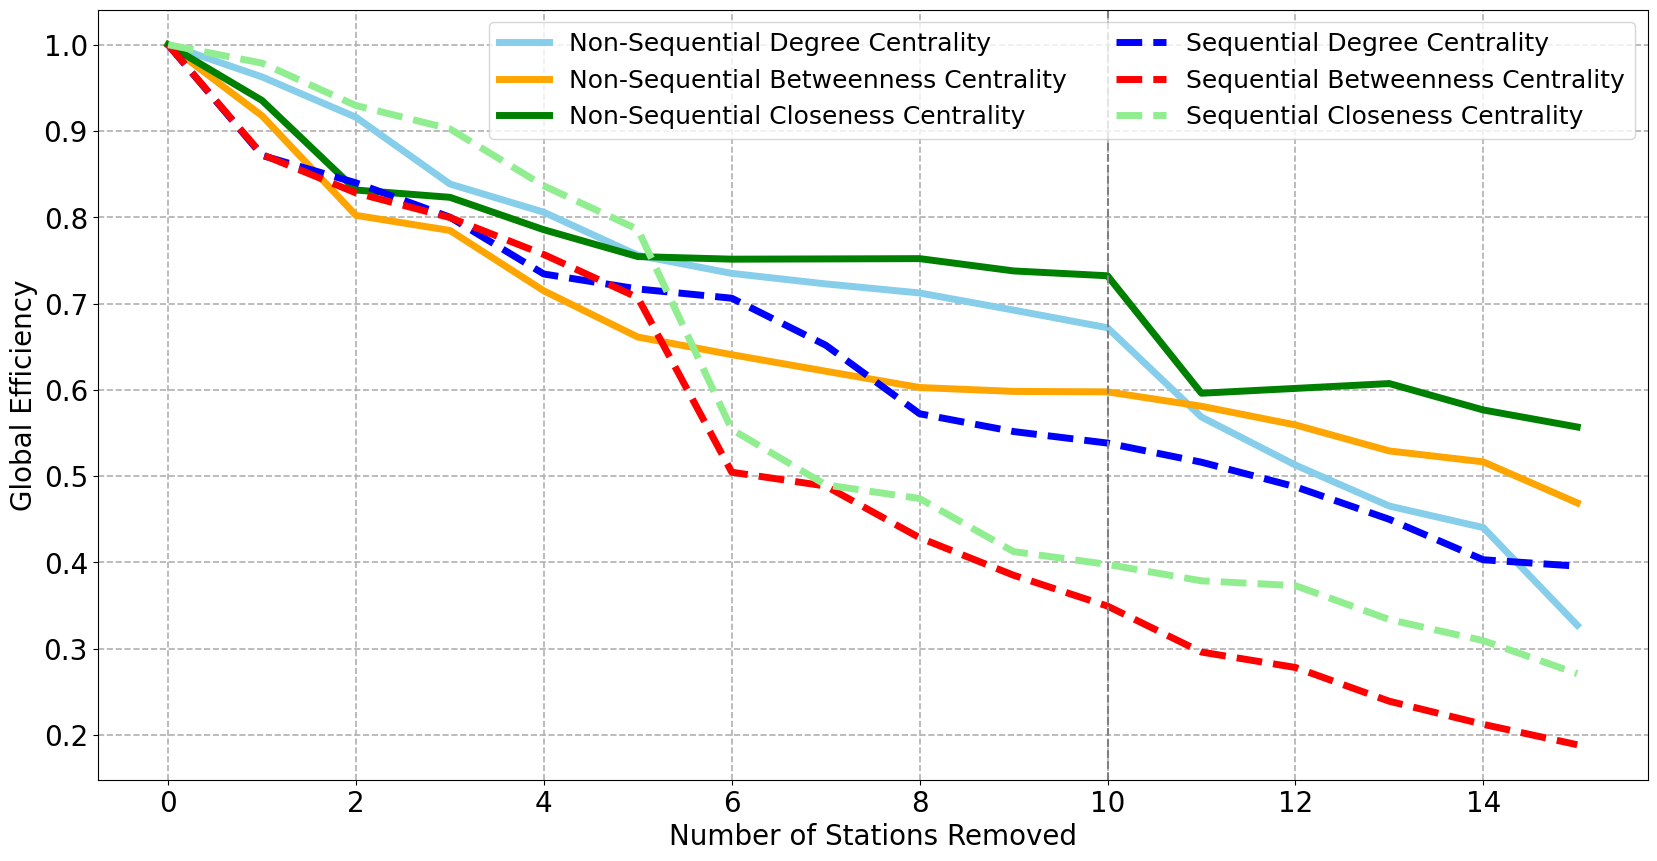

In [58]:
plt.figure(figsize=(20, 10))

plt.plot(range(16), global_dc_nonseq_norm[:16], label='Non-Sequential Degree Centrality', color='skyblue', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(16), global_bc_nonseq_norm[:16], label='Non-Sequential Betweenness Centrality', color='orange', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(16), global_cc_nonseq_norm[:16], label='Non-Sequential Closeness Centrality', color='green', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(16), global_dc_seq_norm[:16], label='Sequential Degree Centrality', color='blue', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(16), global_bc_seq_norm[:16], label='Sequential Betweenness Centrality', color='red', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(16), global_cc_seq_norm[:16], label='Sequential Closeness Centrality', color='lightgreen', linestyle='--',linewidth=5,markersize=12)

plt.xlabel('Number of Stations Removed', fontsize=20)
plt.ylabel('Global Efficiency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.axvline(x=10, color='gray', linestyle='--')
plt.legend(ncol=2,fontsize=18)

plt.savefig('output/global_efficiency1.png',dpi=300)
plt.show()


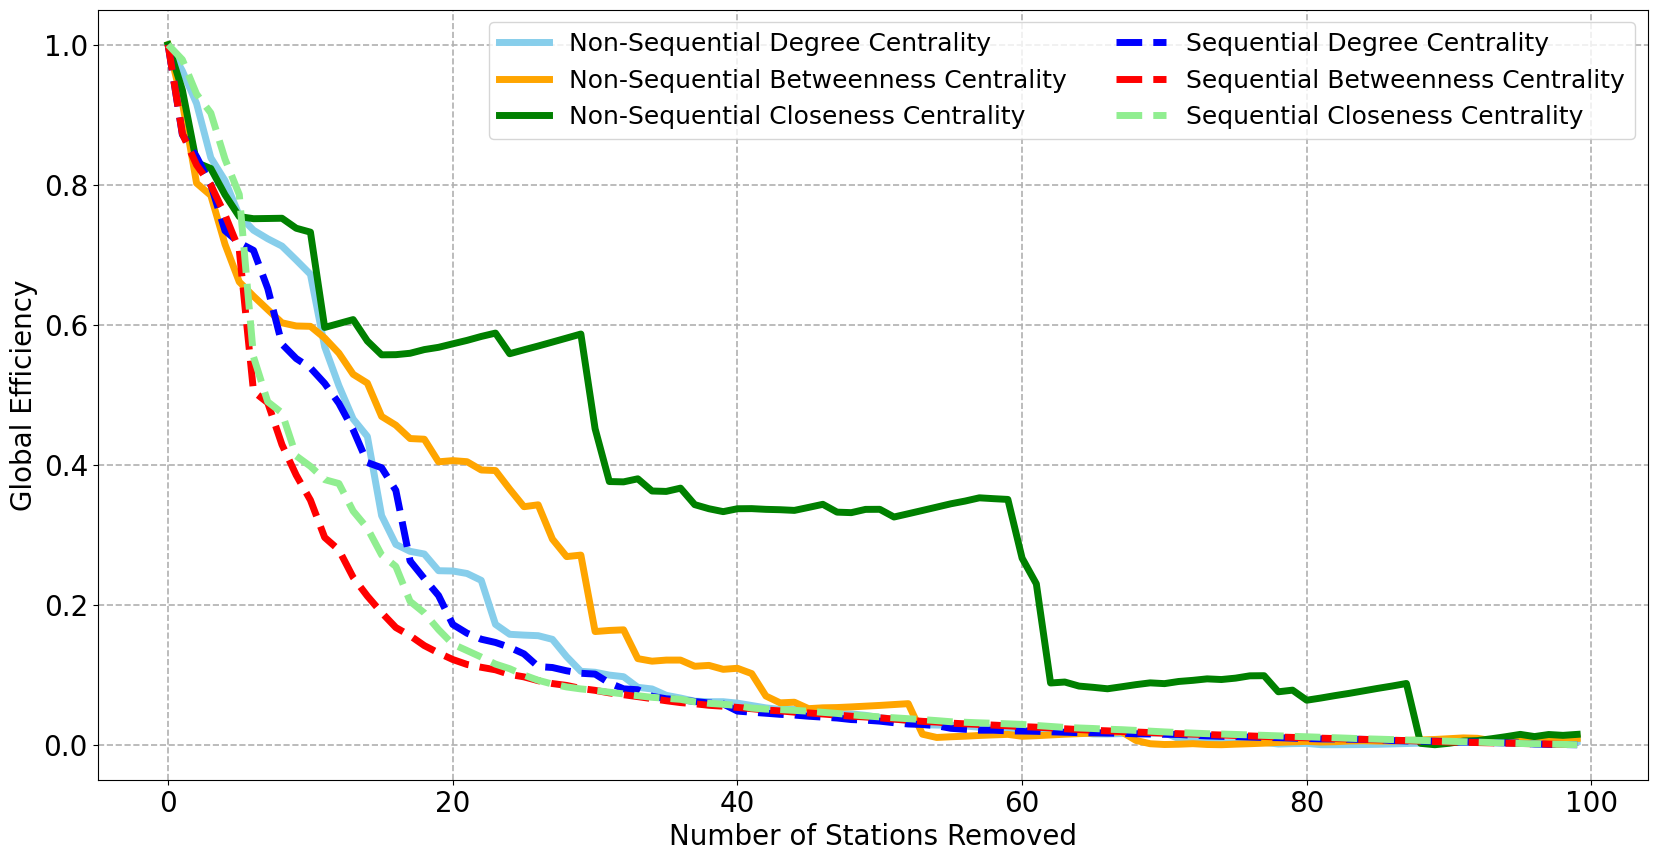

In [59]:
plt.figure(figsize=(20, 10))
plt.plot(range(100), global_dc_nonseq_norm[:100], label='Non-Sequential Degree Centrality', color='skyblue', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(100), global_bc_nonseq_norm[:100], label='Non-Sequential Betweenness Centrality', color='orange', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(100), global_cc_nonseq_norm[:100], label='Non-Sequential Closeness Centrality', color='green', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(100), global_dc_seq_norm[:100], label='Sequential Degree Centrality', color='blue', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(100), global_bc_seq_norm[:100], label='Sequential Betweenness Centrality', color='red', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(100), global_cc_seq_norm[:100], label='Sequential Closeness Centrality', color='lightgreen', linestyle='--',linewidth=5,markersize=12)
plt.xlabel('Number of Stations Removed', fontsize=20)
plt.ylabel('Global Efficiency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.legend(ncol=2,fontsize=18)

plt.savefig('output/global_efficiency2.png',dpi=300)
plt.show()

In [60]:
global_dc_nonseq_decrease = ((global_dc_nonseq_norm[0] - global_dc_nonseq_norm[10]) / global_dc_nonseq_norm[0]) * 100
global_cc_nonseq_decrease = ((global_cc_nonseq_norm[0] - global_cc_nonseq_norm[10]) / global_cc_nonseq_norm[0]) * 100
global_bc_nonseq_decrease = ((global_bc_nonseq_norm[0] - global_bc_nonseq_norm[10]) / global_bc_nonseq_norm[0]) * 100
global_dc_seq_decrease = ((global_dc_seq_norm[0] - global_dc_seq_norm[10]) / global_dc_seq_norm[0]) * 100
global_cc_seq_decrease = ((global_cc_seq_norm[0] - global_cc_seq_norm[10]) / global_cc_seq_norm[0]) * 100
global_bc_seq_decrease = ((global_bc_seq_norm[0] - global_bc_seq_norm[10]) / global_bc_seq_norm[0]) * 100

data_global_decrease = {'Centrality Measure': ['Degree(nonseq)', 'Closeness(nonseq)', 'Betweenness(nonseq)', 'Degree (seq)', 'Closeness (seq)', 'Betweenness (seq)'],
                        'Global Efficiency Decrease (%)': [global_dc_nonseq_decrease, global_cc_nonseq_decrease, global_bc_nonseq_decrease,
                                                           global_dc_seq_decrease, global_cc_seq_decrease, global_bc_seq_decrease]}
df_global_decrease = pd.DataFrame(data_global_decrease)
print(df_global_decrease)

    Centrality Measure  Global Efficiency Decrease (%)
0       Degree(nonseq)                       32.800370
1    Closeness(nonseq)                       26.777002
2  Betweenness(nonseq)                       40.230861
3         Degree (seq)                       46.167198
4      Closeness (seq)                       60.229742
5    Betweenness (seq)                       65.059324


In [61]:
average_dc_nonseq_decrease = ((average_dc_nonseq_norm[0] - average_dc_nonseq_norm[10]) / average_dc_nonseq_norm[0]) * 100
average_cc_nonseq_decrease = ((average_cc_nonseq_norm[0] - average_cc_nonseq_norm[10]) / average_cc_nonseq_norm[0]) * 100
average_bc_nonseq_decrease = ((average_bc_nonseq_norm[0] - average_bc_nonseq_norm[10]) / average_bc_nonseq_norm[0]) * 100
average_dc_seq_decrease = ((average_dc_seq_norm[0] - average_dc_seq_norm[10]) / average_dc_seq_norm[0]) * 100
average_cc_seq_decrease = ((average_cc_seq_norm[0] - average_cc_seq_norm[10]) / average_cc_seq_norm[0]) * 100
average_bc_seq_decrease = ((average_bc_seq_norm[0] - average_bc_seq_norm[10]) / average_bc_seq_norm[0]) * 100

data_average_decrease = {'Centrality Measure': ['Degree(nonseq)', 'Closeness(nonseq)', 'Betweenness(nonseq)', 'Degree (seq)', 'Closeness (seq)', 'Betweenness (seq)'],
                        'Average Degree Decrease (%)': [average_dc_nonseq_decrease, average_cc_nonseq_decrease, average_bc_nonseq_decrease,
                                                           average_dc_seq_decrease, average_cc_seq_decrease, average_bc_seq_decrease]}
df_average_decrease = pd.DataFrame(data_average_decrease)
print(df_average_decrease)

    Centrality Measure  Average Degree Decrease (%)
0       Degree(nonseq)                    24.788579
1    Closeness(nonseq)                    37.564842
2  Betweenness(nonseq)                    33.017454
3         Degree (seq)                    21.093367
4      Closeness (seq)                    19.383763
5    Betweenness (seq)                    18.773910


## 2. Flows: weighted network

> Include passengers into the underground, and assess whether different 
measures need to be used when flows are considered. The network to use in this section is the 
weighted network given to you in the coursework, where the flows of passengers were assigned to the 
links between stations

> 14

In [212]:
G = nx.read_graphml('data/london.graph')
london_flow = pd.read_csv('https://raw.githubusercontent.com/yiyansun/urbsim/main/assessment/data/london_flows.csv')
london_flow.head()

station_origin station_destination  flows  population   jobs     distance
0     Abbey Road   Bank and Monument      0         599  78549  8131.525097
1     Abbey Road             Beckton      1         599    442  8510.121774
2     Abbey Road           Blackwall      3         599    665  3775.448872
3     Abbey Road        Canary Wharf      1         599  58772  5086.514220
4     Abbey Road        Canning Town     37         599  15428  2228.923167

### II.1. Old vs new measure
> Consider the centrality measure derived in I. indicating the most relevant stations for assessing 
the vulnerability of the underground. What would you need to do to adjust this measure for a 
weighted network? Recompute the ranking of the 10 most important nodes according to this adjusted 
measure. Do you find the same ones as in I.1?    3


In [200]:
G2 = G.copy()

# Add the flows to the edges
for i, row in london_flow.iterrows():
    origin = row['station_origin']
    destination = row['station_destination']
    flow = row['flows']
    
    if G2.has_edge(origin, destination):
        G2[origin][destination]['flows_inv'] = 1 / ( flow + .0001)

In [201]:
G = G2

In [196]:
clo_w = nx.closeness_centrality(G2, distance='flows_inv')

In [204]:
# weighted betweenness centrality
bet_w=nx.betweenness_centrality(G2,normalized=True, weight='flows_inv')
nx.set_node_attributes(G2,bet_w,'betweenness_w')
df_w = pd.DataFrame(index=G2.nodes())
df_w['station_name_w'] = pd.Series(nx.get_node_attributes(G2, 'station_name'))
df_w['betweenness_w'] = pd.Series(nx.get_node_attributes(G2, 'betweenness_w'))

df_sorted_w = df_w.sort_values(["betweenness_w"], ascending=False)
betweenness_centrality_w = df_sorted_w[0:10]
betweenness_centrality_w

station_name_w  betweenness_w
Bank and Monument                   NaN       0.524825
Stratford                           NaN       0.448509
Liverpool Street                    NaN       0.398070
West Ham                            NaN       0.351742
King's Cross St. Pancras            NaN       0.345840
Green Park                          NaN       0.308897
Waterloo                            NaN       0.297531
Canning Town                        NaN       0.277268
Westminster                         NaN       0.273170
Moorgate                            NaN       0.271867

In [67]:
# unweighted betweenness centrality
bet_t=nx.betweenness_centrality(G,normalized=True,weight='length')

# add these values to the nodes attributes:
nx.set_node_attributes(G,bet_t,'betweenness')
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['betweenness'] = pd.Series(nx.get_node_attributes(G, 'betweenness'))

df_sorted = df.sort_values(["betweenness"], ascending=False)
betweenness_centrality = df_sorted[0:10]
betweenness_centrality

station_name  betweenness
Bank and Monument                 NaN     0.221253
King's Cross St. Pancras          NaN     0.209185
Stratford                         NaN     0.182306
Oxford Circus                     NaN     0.169937
Euston                            NaN     0.165915
Baker Street                      NaN     0.152256
Earl's Court                      NaN     0.143797
Shadwell                          NaN     0.139449
Waterloo                          NaN     0.130426
South Kensington                  NaN     0.129511

In [68]:
top_stations_bc_flows = pd.concat([betweenness_centrality.reset_index(drop=True),
                                 betweenness_centrality_w.reset_index(drop=True)], axis=1)

top_stations_bc_flows.insert(0, 'Rank', range(1, 11))

top_stations_bc_flows

Rank station_name  betweenness station_name_w  betweenness_w
0     1          NaN     0.221253            NaN       0.524825
1     2          NaN     0.209185            NaN       0.448509
2     3          NaN     0.182306            NaN       0.398070
3     4          NaN     0.169937            NaN       0.351742
4     5          NaN     0.165915            NaN       0.345840
5     6          NaN     0.152256            NaN       0.308897
6     7          NaN     0.143797            NaN       0.297531
7     8          NaN     0.139449            NaN       0.277268
8     9          NaN     0.130426            NaN       0.273170
9    10          NaN     0.129511            NaN       0.271867

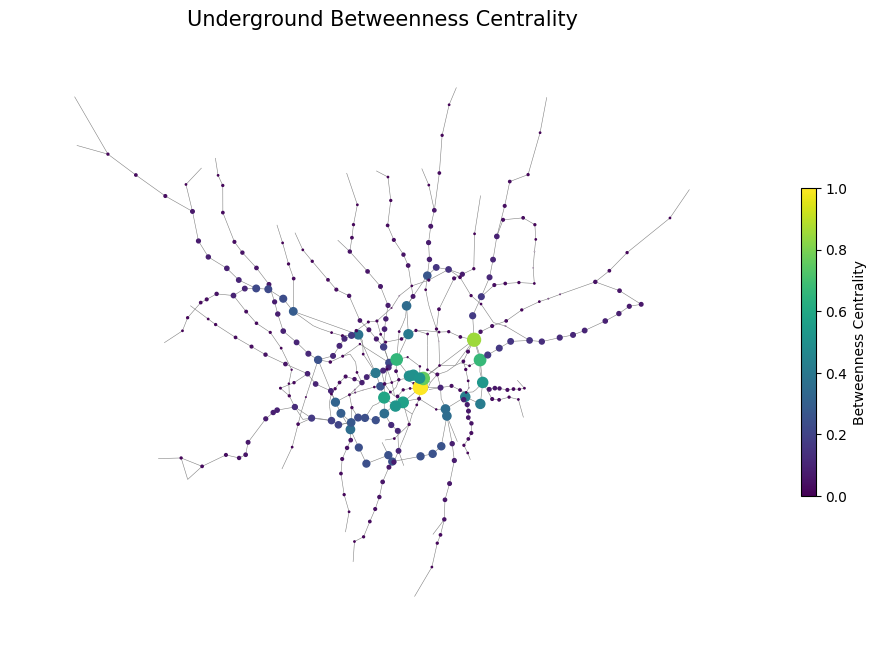

In [69]:
betweenness_f_values=[(i[1]['betweenness_w']) for i in G2.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_w']/max(betweenness_f_values)) for i in G2.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_f_values))*100 for i in G2.nodes(data=True)]

pos=pos
fig, ax = plt.subplots(figsize=(12,8))
nx.draw_networkx_edges(G2, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G2,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)
plt.colorbar(nod,label="Betweenness Centrality",orientation="vertical", shrink=0.5)
plt.axis("off")
plt.title("Underground Betweenness Centrality",fontsize=15)
plt.savefig("output/betweenness_centrality_flows.png", format="PNG")
plt.show()

In [70]:
G_un=G.to_undirected()
new_weight = {}

for e1, e2, c in G_un.edges(data='flows'):
    if c is None or c == 0:
        new_weight[(e1, e2)] = 0
    else:
        new_weight[(e1, e2)] = 1 / c

nx.set_edge_attributes(G_un, new_weight, 'new_weight')

nx.to_pandas_edgelist(G_un)

source         target       length     line_name  new_weight  \
0        Wembley Park      Kingsbury  2916.771558       Jubilee    0.000081   
1        Wembley Park        Neasden  2353.165938       Jubilee    0.000148   
2        Wembley Park   Preston Road  1419.735166  Metropolitan    0.000027   
3        Wembley Park  Finchley Road  7266.373927  Metropolitan    0.000018   
4           Kingsbury     Queensbury  1245.995234       Jubilee    0.000106   
..                ...            ...          ...           ...         ...   
462  Hounslow Central  Hounslow East   745.684383    Piccadilly    0.000074   
463     Hounslow East       Osterley   967.494672    Piccadilly    0.000063   
464          Osterley   Boston Manor  2560.814291    Piccadilly    0.000057   
465      Boston Manor    Northfields   930.852145    Piccadilly    0.000054   
466          Vauxhall        Pimlico   825.328253      Victoria    0.000016   

     flows  
0    12356  
1     6744  
2    36601  
3    55216  
4     9419  
..     ...  
462  13469  
463  15935  
464  17445  
465  18598  
466  61585  

[467 rows x 6 columns]

In [71]:
degree_centrality_w = pd.DataFrame(nx.degree(G_un,weight='new_weight'), columns=['degree_w(nonseq)', 'value']) \
                      .sort_values(by='value', ascending=False) \
                      .iloc[:10]
degree_centrality_w

degree_w(nonseq)     value
363             Lambeth North  0.011066
315         Elephant & Castle  0.010761
264                Abbey Road  0.004579
87            Theobalds Grove  0.004555
387       Heathrow Terminal 4  0.004063
389  Heathrow Terminals 2 & 3  0.003916
263     Stratford High Street  0.003589
88                   Cheshunt  0.003484
265                 Star Lane  0.003176
6                    West Ham  0.002919

In [72]:
closeness_centrality_w = pd.DataFrame.from_dict(nx.closeness_centrality(G_un, distance='new_weight'), 
                                               orient='index', columns=['value']) \
                         .rename_axis('closeness_w(nonseq)').reset_index() \
                         .sort_values(by='value', ascending=False) \
                         .iloc[:10]
closeness_centrality_w

closeness_w(nonseq)        value
16           Green Park  2377.569519
15          Westminster  2372.542016
14             Waterloo  2367.998823
50    Bank and Monument  2364.577066
45        Oxford Circus  2355.796242
17          Bond Street  2352.780789
204            Victoria  2345.842679
51     Liverpool Street  2345.155626
341       Warren Street  2329.989523
232            Moorgate  2325.095146

In [73]:
betweenness_centrality_w = pd.DataFrame.from_dict(nx.betweenness_centrality(G_un, weight='new_weight'), 
                                                 orient='index', columns=['value']) \
                            .rename_axis('betweenness_w(nonseq)').reset_index() \
                            .sort_values(by='value', ascending=False) \
                            .iloc[:10]
betweenness_centrality_w

betweenness_w(nonseq)     value
16             Green Park  0.562563
50      Bank and Monument  0.498227
14               Waterloo  0.399803
15            Westminster  0.371736
51       Liverpool Street  0.332456
5               Stratford  0.327381
17            Bond Street  0.288177
150                Euston  0.279624
45          Oxford Circus  0.265752
341         Warren Street  0.249574

In [74]:
top_stations_w_nonseq = pd.concat([degree_centrality_w.reset_index(drop=True),
                          closeness_centrality_w.reset_index(drop=True),
                          betweenness_centrality_w.reset_index(drop=True)], axis=1)

top_stations_w_nonseq .insert(0,'Rank',range(1,11))

top_stations_w_nonseq

Rank          degree_w(nonseq)     value closeness_w(nonseq)        value  \
0     1             Lambeth North  0.011066          Green Park  2377.569519   
1     2         Elephant & Castle  0.010761         Westminster  2372.542016   
2     3                Abbey Road  0.004579            Waterloo  2367.998823   
3     4           Theobalds Grove  0.004555   Bank and Monument  2364.577066   
4     5       Heathrow Terminal 4  0.004063       Oxford Circus  2355.796242   
5     6  Heathrow Terminals 2 & 3  0.003916         Bond Street  2352.780789   
6     7     Stratford High Street  0.003589            Victoria  2345.842679   
7     8                  Cheshunt  0.003484    Liverpool Street  2345.155626   
8     9                 Star Lane  0.003176       Warren Street  2329.989523   
9    10                  West Ham  0.002919            Moorgate  2325.095146   

  betweenness_w(nonseq)     value  
0            Green Park  0.562563  
1     Bank and Monument  0.498227  
2              Waterloo  0.399803  
3           Westminster  0.371736  
4      Liverpool Street  0.332456  
5             Stratford  0.327381  
6           Bond Street  0.288177  
7                Euston  0.279624  
8         Oxford Circus  0.265752  
9         Warren Street  0.249574

In [75]:
degree_centrality_w_seq=[]
G_dc_w_seq=G_un.copy()
for i in range(0,10):
    degree=nx.degree(G_dc_w_seq,weight='new_weight')
    nx.set_node_attributes(G_dc_w_seq,dict(degree),'degree')
    degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
    node6=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
    degree_centrality_w_seq.append(node6[0])
    G_dc_w_seq.remove_nodes_from([node6[0]])

degree_centrality_w_seq

['Lambeth North',
 'Abbey Road',
 'Theobalds Grove',
 'Heathrow Terminal 4',
 'Star Lane',
 'Grange Hill',
 'Chalfont & Latimer',
 'Tower Hill',
 'Emerson Park',
 'Chiswick Park']

In [76]:
closeness_centrality_w_seq=[]
G_cc_w_seq=G_un.copy()
for i in range(0,10):
    closeness_w_seq=nx.closeness_centrality(G_cc_w_seq, distance = 'new_weight')
    nx.set_node_attributes(G_cc_w_seq,closeness_w_seq,'closeness')
    closeness_df=pd.DataFrame.from_dict(closeness_w_seq,columns=['closeness'],orient='index')
    node5=list(closeness_df.sort_values('closeness',axis = 0,ascending = False).index)
    closeness_centrality_w_seq.append(node5[0])
    G_cc_w_seq.remove_nodes_from([node5[0]])
    
closeness_centrality_w_seq

['Green Park',
 'Bank and Monument',
 "King's Cross St. Pancras",
 'Waterloo',
 'Stockwell',
 'West Brompton',
 'Highbury & Islington',
 'Blackhorse Road',
 'Bond Street',
 'Notting Hill Gate']

In [77]:
betweeness_centrality_w_seq=[]
G_bc_w_seq=G_un.copy()

for i in range(0,10):
    # recalculate the centrality values and remove the most largest one
    betweeness_w_seq=nx.betweenness_centrality(G_bc_w_seq, weight='new_weight',normalized=False)
    nx.set_node_attributes(G_bc_w_seq,betweeness_w_seq,'betweenness')
    betweenness_df=pd.DataFrame.from_dict(betweeness_w_seq,columns=['betweenness'],orient='index')
    node4=list(betweenness_df.sort_values('betweenness',axis = 0,ascending = False).index)
    betweeness_centrality_w_seq.append(node4[0])
    G_bc_w_seq.remove_nodes_from([node4[0]])
    
betweeness_centrality_w_seq

['Green Park',
 'Bank and Monument',
 "King's Cross St. Pancras",
 'Canada Water',
 'Finchley Road',
 'Highbury & Islington',
 'Blackhorse Road',
 "Earl's Court",
 'Willesden Junction',
 "Shepherd's Bush"]

In [79]:
top_stations_w_seq= pd.DataFrame({'degree_w(seq)': degree_centrality_w_seq, 'closeness_w(seq)': closeness_centrality_w_seq, 'betweeness_w(seq)': betweeness_centrality_w_seq})
top_stations_w_seq .insert(0,'Rank',range(1,11))
top_stations_w_seq

Rank        degree_w(seq)          closeness_w(seq)  \
0     1        Lambeth North                Green Park   
1     2           Abbey Road         Bank and Monument   
2     3      Theobalds Grove  King's Cross St. Pancras   
3     4  Heathrow Terminal 4                  Waterloo   
4     5            Star Lane                 Stockwell   
5     6          Grange Hill             West Brompton   
6     7   Chalfont & Latimer      Highbury & Islington   
7     8           Tower Hill           Blackhorse Road   
8     9         Emerson Park               Bond Street   
9    10        Chiswick Park         Notting Hill Gate   

          betweeness_w(seq)  
0                Green Park  
1         Bank and Monument  
2  King's Cross St. Pancras  
3              Canada Water  
4             Finchley Road  
5      Highbury & Islington  
6           Blackhorse Road  
7              Earl's Court  
8        Willesden Junction  
9           Shepherd's Bush

In [80]:
# Calculate the global efficiency of Graph
def my_global_efficiency_w(Graph):
    n = len(Graph)
    denom = n * (n - 1)
    if denom != 0:
        lengths = nx.all_pairs_dijkstra_path_length(Graph, weight = 'new_weight')
        g_eff = 0
        for source, targets in lengths:
            for target, distance in targets.items():
                if distance > 0:
                    g_eff += 1 / distance
        g_eff /= denom
    else:
        g_eff = 0
        
    return g_eff

In [ ]:
# merge
betweeness_all = pd.merge(df_sbetweeness, df_nsbetweeness, left_index=True, right_index=True)

# keep columns below:
desired_columns = [
    "Station Removed (seq)",
    "Avg. Shortest Path (seq)",
    "Global efficiency (seq)",
    "Station Removed (non seq)",
    "Avg. Shortest Path (non seq)",
    "Global efficiency (non seq)",
]

# filter & print
betweeness_all = betweeness_all[[col for col in desired_columns if col in betweeness_all.columns]]
betweeness_all

Station Removed (seq)  Avg. Shortest Path (seq)  \
1                 Stratford                 14.496447   
2  King's Cross St. Pancras                 15.310134   
3                  Waterloo                 15.795939   
4         Bank and Monument                 16.789631   
5              Canada Water                 19.029234   
6            West Hampstead                 13.462360   
7              Earl's Court                 14.206450   
8           Shepherd's Bush                 13.792046   
9                    Euston                 13.821885   

   Global efficiency (seq) Station Removed (non seq)  \
1                 0.098215         Bank and Monument   
2                 0.093431          Liverpool Street   
3                 0.090360  King's Cross St. Pancras   
4                 0.085753                  Waterloo   
5                 0.080369                Green Park   
6                 0.108644                    Euston   
7                 0.104054               Westminster   
8                 0.109139              Baker Street   
9                 0.113125             Finchley Road   

   Avg. Shortest Path (non seq)  Global efficiency (non seq)  
1                     14.872497                     0.094833  
2                     15.031209                     0.093854  
3                     16.030742                     0.088929  
4                     16.756742                     0.086028  
5                     17.180865                     0.084001  
6                     16.807372                     0.086321  
7                     16.975059                     0.085663  
8                     17.586339                     0.082813  
9                     17.986979                     0.081751

In [227]:
# betweenness non-seq
bet_london_w=nx.betweenness_centrality(G_un,weight='new_weight', normalized=False)
betweenness_df=pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_w'],orient='index')
node1=list(betweenness_df.sort_values('betweenness_w',axis = 0,ascending = False).index)
score_b_1=[]
scoreG_b_1=[]
g_1=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_1.append(nx.average_shortest_path_length(g_1))
    scoreG_b_1.append(my_global_efficiency_w(g_1))
    g_1.remove_nodes_from([node1[i]])
    
# closeness non-seq
closeness_w=nx.closeness_centrality(G_un,distance='new_weight')
closeness_df=pd.DataFrame.from_dict(closeness_w,columns=['closeness_w'],orient='index')
node2=list(closeness_df.sort_values('closeness_w',axis = 0,ascending = False).index)
score_b_2=[]
scoreG_b_2=[]
g_2=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_2.append(nx.average_shortest_path_length(g_2))
    scoreG_b_2.append(my_global_efficiency_w(g_2))
    g_2.remove_nodes_from([node2[i]])

# degree non-seq
degree=G_un.degree(weight='new_weight')
degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
node3=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
score_b_3=[]
scoreG_b_3=[]
g_3=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_3.append(nx.average_shortest_path_length(g_3))
    scoreG_b_3.append(my_global_efficiency_w(g_3))    
    g_3.remove_nodes_from([node3[i]])

#betweenness seq
score_b_4=[]
scoreG_b_4=[]
g_4=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_4.append(nx.average_shortest_path_length(g_4))
    scoreG_b_4.append(my_global_efficiency_w(g_4)) 
    bet_london_w=nx.betweenness_centrality(g_4, weight='new_weight',normalized=False)
    nx.set_node_attributes(g_4,bet_london_w,'betweenness_w')
    betweenness_df=pd.DataFrame.from_dict(bet_london_w,columns=['betweenness_w'],orient='index')
    node4=list(betweenness_df.sort_values('betweenness_w',axis = 0,ascending = False).index)
    g_4.remove_nodes_from([node4[0]])

# closeness seq
score_b_5=[]
scoreG_b_5=[]
g_5=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_5.append(nx.average_shortest_path_length(g_5))
    scoreG_b_5.append(my_global_efficiency_w(g_5))     
    closeness_w=nx.closeness_centrality(g_5,distance='new_weight')
    nx.set_node_attributes(g_5,closeness_w,'closeness_w')
    closeness_df=pd.DataFrame.from_dict(closeness_w,columns=['closeness_w'],orient='index')
    node5=list(closeness_df.sort_values('closeness_w',axis = 0,ascending = False).index)
    g_5.remove_nodes_from([node5[0]])
    
# degree seq
score_b_6=[]
scoreG_b_6=[]
g_6=G_un.copy()
for i in range(0,len(list(G_un.nodes))):
    score_b_6.append(nx.average_shortest_path_length(g_6))
    scoreG_b_6.append(my_global_efficiency_w(g_6))    
    degree=g_6.degree(weight='new_weight')
    nx.set_node_attributes(g_6,dict(degree),'degree')
    degree_df=pd.DataFrame.from_dict(dict(degree),columns=['degree'],orient='index')
    node6=list(degree_df.sort_values('degree',axis = 0,ascending = False).index)
    g_6.remove_nodes_from([node6[0]])

NetworkXError: Graph is not connected.

In [86]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

score_b_1 = NormalizeData(score_b_1[0:100])
score_b_2 = NormalizeData(score_b_2[0:100])
score_b_3 = NormalizeData(score_b_3[0:100])
score_b_4 = NormalizeData(score_b_4[0:100])
score_b_5 = NormalizeData(score_b_5[0:100])
score_b_6 = NormalizeData(score_b_6[0:100])

scoreG_b_1 = NormalizeData(scoreG_b_1[0:100])
scoreG_b_2 = NormalizeData(scoreG_b_2[0:100])
scoreG_b_3 = NormalizeData(scoreG_b_3[0:100])
scoreG_b_4 = NormalizeData(scoreG_b_4[0:100])
scoreG_b_5 = NormalizeData(scoreG_b_5[0:100])
scoreG_b_6 = NormalizeData(scoreG_b_6[0:100])

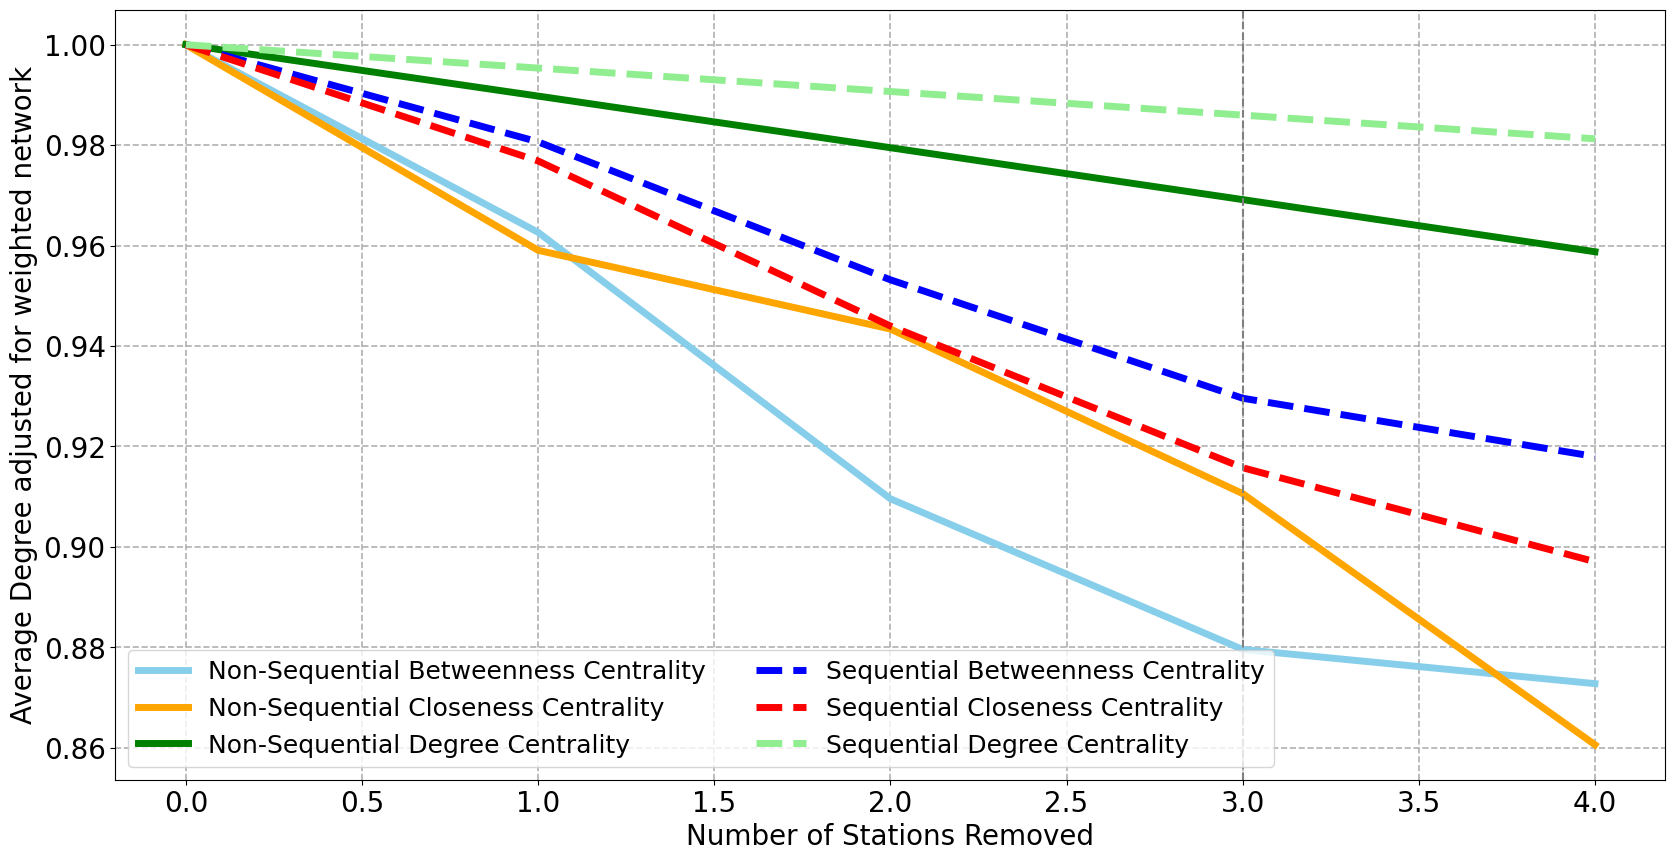

In [225]:
# plot
plt.figure(figsize=(20, 10))
plt.plot(range(5), score_b_1[:5], label='Non-Sequential Betweenness Centrality', color='skyblue', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(5), score_b_2[:5], label='Non-Sequential Closeness Centrality', color='orange', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(5), score_b_3[:5], label='Non-Sequential Degree Centrality', color='green', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(5), score_b_4[:5], label='Sequential Betweenness Centrality', color='blue', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(5), score_b_5[:5], label='Sequential Closeness Centrality', color='red', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(5), score_b_6[:5], label='Sequential Degree Centrality', color='lightgreen', linestyle='--',linewidth=5,markersize=12)
plt.xlabel('Number of Stations Removed', fontsize=20)
plt.ylabel('Average Degree adjusted for weighted network', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.axvline(x=3, color='gray', linestyle='--')
plt.legend(ncol=2,fontsize=18)

plt.savefig('output/average_degree_flows2.png',dpi=300)
plt.show()

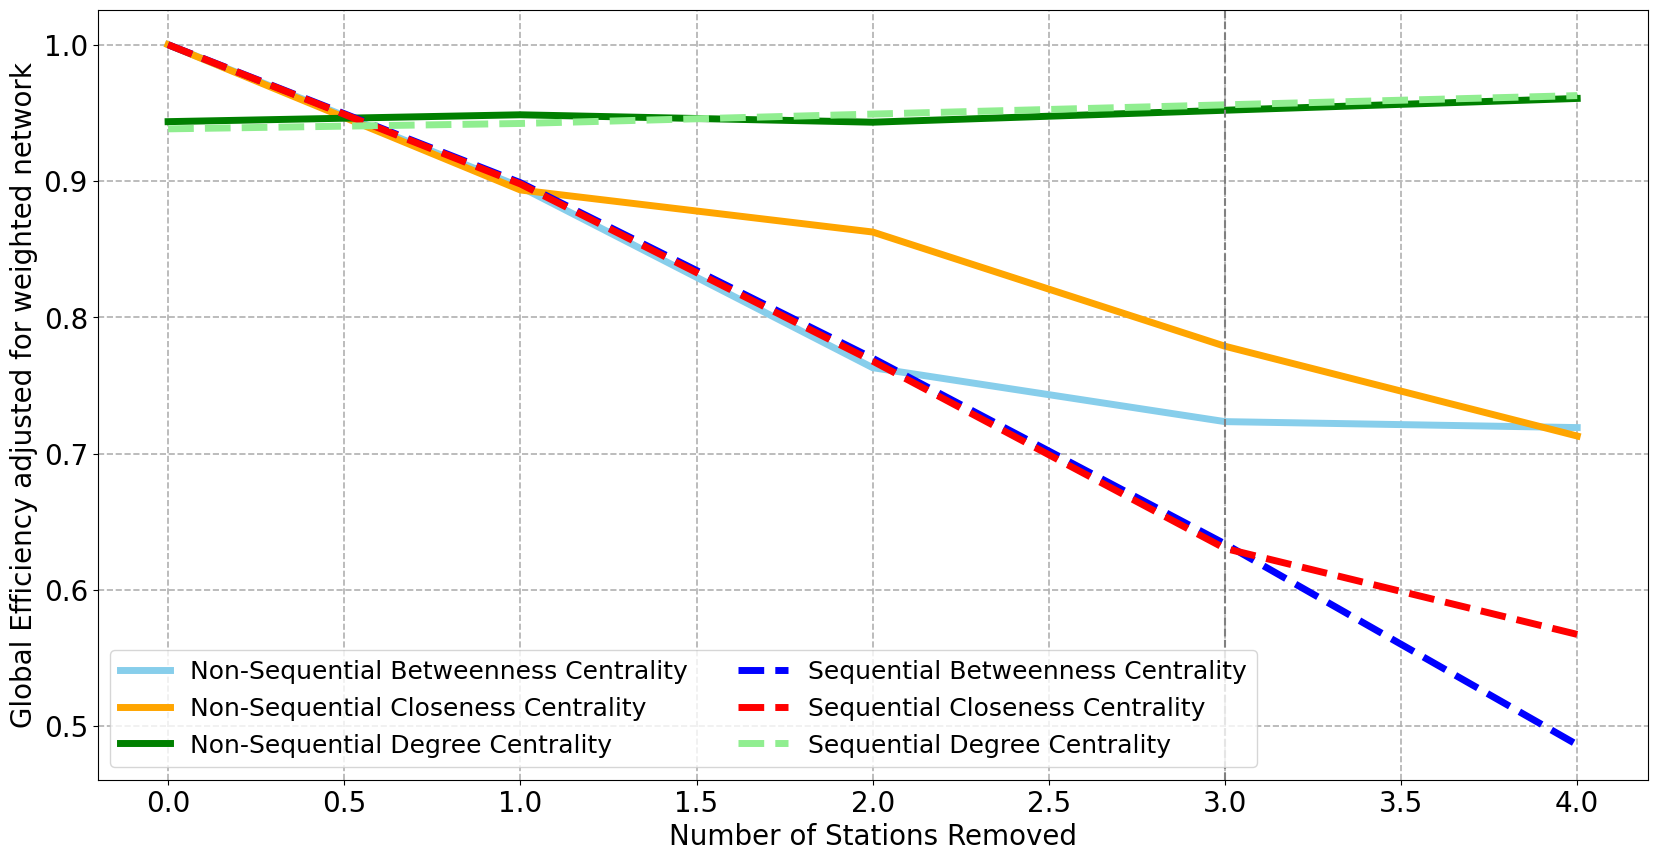

In [226]:
# plot
plt.figure(figsize=(20, 10))
plt.plot(range(5), scoreG_b_1[:5], label='Non-Sequential Betweenness Centrality', color='skyblue', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(5), scoreG_b_2[:5], label='Non-Sequential Closeness Centrality', color='orange', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(5), scoreG_b_3[:5], label='Non-Sequential Degree Centrality', color='green', linestyle='-',linewidth=5,markersize=12)
plt.plot(range(5), scoreG_b_4[:5], label='Sequential Betweenness Centrality', color='blue', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(5), scoreG_b_5[:5], label='Sequential Closeness Centrality', color='red', linestyle='--',linewidth=5,markersize=12)
plt.plot(range(5), scoreG_b_6[:5], label='Sequential Degree Centrality', color='lightgreen', linestyle='--',linewidth=5,markersize=12)
plt.xlabel('Number of Stations Removed', fontsize=20)
plt.ylabel('Global Efficiency adjusted for weighted network', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.axvline(x=3, color='gray', linestyle='--')
plt.legend(ncol=2,fontsize=18)

plt.savefig('output/global_efficiency_flows2.png',dpi=300)
plt.show()

In [213]:
G2 = G.copy()

#Invert weights
for u, v, d in G2.edges(data=True):
    d['flows_inv'] =  1 / (d.get('flows', 0) + .001)

#Compute
bet_london_w = nx.betweenness_centrality(G2,weight='flows_inv',normalized=True)

#Set attributes
nx.set_node_attributes(G,bet_london_w,'betweenness_f')

df = pd.DataFrame(index=G2.nodes())
df['betweenness_f'] = pd.Series(nx.get_node_attributes(G, 'betweenness_f'))

df_sorted = df.sort_values(["betweenness_f"], ascending=False)

#Save for later
flow_betweenness_top_ten = df_sorted[0:15]

flow_betweenness_top_ten

betweenness_f
Green Park                     0.572556
Bank and Monument              0.505288
Waterloo                       0.416429
Westminster                    0.381366
Liverpool Street               0.336817
Stratford                      0.331291
Bond Street                    0.291830
Euston                         0.284236
Oxford Circus                  0.270764
Warren Street                  0.254286
Baker Street                   0.241441
King's Cross St. Pancras       0.219850
Victoria                       0.200188
Earl's Court                   0.197043
Highbury & Islington           0.189812

Stations Removed: 'Green Park', "King's Cross St. Pancras", 'Bank and Monument'

Shortest Path List: 13.845482533139965, 14.68879938626774, 16.012735333804535

Global Efficiency List: 0.09918903381122582, 0.09437778069730432, 0.08794482883208334

In [198]:
def global_efficiency_weighted(G):
    shortest_paths = dict(nx.shortest_path_length(G, weight='flows'))
    total_efficiency = 0
    n = len(G.nodes())
    valid_pairs = 0
    
    for i in G.nodes():
        for j in G.nodes():
            if i != j and shortest_paths[i][j] != 0:
                total_efficiency += 1 / shortest_paths[i][j]
                valid_pairs += 1

    if valid_pairs == 0:
        return 0
    
    global_efficiency = total_efficiency / (valid_pairs*2)
    return global_efficiency

def average_weighted_shortest_path_length(G):
    shortest_paths = dict(nx.all_pairs_dijkstra_path_length(G, weight='flows'))
    total_path_length = 0
    n = len(G.nodes())
    
    for i in G.nodes():
        for j in G.nodes():
            if i != j:
                total_path_length += shortest_paths[i][j]
    
    average_path_length = total_path_length / (n * (n - 1))
    return average_path_length

In [217]:
# weighted betweenness centrality
bet_w=nx.betweenness_centrality(G2,normalized=True, weight='flows_inv')
nx.set_node_attributes(G2,bet_w,'betweenness_w')
df_w = pd.DataFrame(index=G2.nodes())
df_w['station_name_w'] = pd.Series(nx.get_node_attributes(G2, 'station_name'))
df_w['betweenness_w'] = pd.Series(nx.get_node_attributes(G2, 'betweenness_w'))

df_sorted_w = df_w.sort_values(["betweenness_w"], ascending=False)
betweenness_centrality_w = df_sorted_w[0:10]
betweenness_centrality_w

station_name_w  betweenness_w
Green Park                   NaN       0.572556
Bank and Monument            NaN       0.505288
Waterloo                     NaN       0.416429
Westminster                  NaN       0.381366
Liverpool Street             NaN       0.336817
Stratford                    NaN       0.331291
Bond Street                  NaN       0.291830
Euston                       NaN       0.284236
Oxford Circus                NaN       0.270764
Warren Street                NaN       0.254286

In [211]:

G7 = G2.copy()
global_efficiency_w = []
global_efficiency_w.append(global_efficiency_weighted(G7))
diff_glob_w = []
for i in range (1,4):
    bet_w_values=[(j[1]['betweenness_w']) for j in G7.nodes(data=True)]
    # Number of existing nodes:
    l1=list(G7.nodes)
    print('Before removing, there are '+ str(len(l1)) +' nodes.')
    maxbet_w=[n for n in G7.nodes() if G7.nodes[n]['betweenness_w'] == max(bet_w_values)]
    print('Removing' + str(maxbet_w))
    G7.remove_nodes_from(maxbet_w)
    eff = global_efficiency_weighted(G7)
    # number of nodes after the removal
    l2=list(G7.nodes)
    print('After removing, there are '+ str(len(l2)) + ' nodes.')
    global_efficiency_w.append(eff)
    diff_glob_w.append(global_efficiency_w[i-1] - eff)
    print('Global efficiency is '+str(eff)+' after removing.')
    print('---------------------------------------------')
    bet_w=nx.betweenness_centrality(G7,weight='flows',normalized=False)
    nx.set_node_attributes(G7,bet_w,'betweenness_w')

Before removing, there are 401 nodes.
Removing['Bank and Monument']
After removing, there are 400 nodes.
Global efficiency is 3.6976787599478166e-06 after removing.
---------------------------------------------
Before removing, there are 400 nodes.
Removing['West Hampstead']
After removing, there are 399 nodes.
Global efficiency is 3.4251175593013873e-06 after removing.
---------------------------------------------
Before removing, there are 399 nodes.
Removing['Leicester Square']
After removing, there are 398 nodes.
Global efficiency is 3.331057344907172e-06 after removing.
---------------------------------------------
